In [295]:
%pip install squarify
%pip install geopandas
%pip install matplotlib

In [296]:
#Manipulacion y Visualizacion de Datos
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import squarify
import geopandas as gp
from sklearn.model_selection import train_test_split
import scipy.linalg as la

#Para regresion lineal
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

In [297]:
propiedades = pd.read_csv('./properati_argentina_2021.csv')
coordenadas_bsas = gp.read_file(r'./barrios.geojson.json')

# Preprocesamiento de los Datos

## Filtrado del Dataset

### Analisis Exploratorio

Comenzamos con un primer paneo del dataframe. Usamos el metodo "info" y "shape", para ver cuantas filas son, cuantas columnas son, que son las variables, etc.

In [298]:
propiedades.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460154 entries, 0 to 460153
Data columns (total 20 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   id                        460154 non-null  object 
 1   start_date                460154 non-null  object 
 2   end_date                  460154 non-null  object 
 3   created_on                460154 non-null  object 
 4   latitud                   419740 non-null  float64
 5   longitud                  419740 non-null  float64
 6   place_l2                  460154 non-null  object 
 7   place_l3                  437665 non-null  object 
 8   place_l4                  139020 non-null  object 
 9   place_l5                  2430 non-null    object 
 10  place_l6                  0 non-null       float64
 11  operation                 460154 non-null  object 
 12  property_type             460154 non-null  object 
 13  property_rooms            368498 non-null  f

In [299]:
propiedades.shape

(460154, 20)

De esta manera, notamos que el dataframe consta de 460154 filas y 20 columnas que detallan ubicacion, precio, caracteristicas, entre otros detalles de cada propiedad.

### Seleccion de Datos

Ahora realizamos los filtrados iniciales solicitados. Ademas checkeamos que se filtre correctamente el dataframe, y antes y despues de cada filtro observamos las filas resultantes.



El primer filtro se hace en base a los *tipos* de propiedades:

In [300]:
propiedades['property_type'].value_counts()

property_type
Departamento       231358
Casa               120768
Lote                28748
PH                  25910
Local comercial     20546
Oficina             16085
Otro                 7713
Cochera              4111
Depósito             4050
Casa de campo         865
Name: count, dtype: int64

In [301]:
propiedades_filtradas = propiedades[(propiedades['property_type'] == 'Casa') |
                                    (propiedades['property_type'] == 'PH') |
                                    (propiedades['property_type'] == 'Departamento')]

print(f'{"Cantidad de filas: "}{propiedades_filtradas.shape[0]}')
print(f'{"Cantidad de columnas: "}{propiedades_filtradas.shape[1]}')

Cantidad de filas: 378036
Cantidad de columnas: 20


In [302]:
propiedades_filtradas['property_type'].value_counts()

property_type
Departamento    231358
Casa            120768
PH               25910
Name: count, dtype: int64

El segundo filtro se realiza en base a la variable *place_l2*, es decir, la *ciudad* de las propiedades:

In [303]:
propiedades['place_l2'].value_counts()

place_l2
Capital Federal                 157563
Bs.As. G.B.A. Zona Norte         89693
Santa Fe                         47861
Bs.As. G.B.A. Zona Sur           47754
Bs.As. G.B.A. Zona Oeste         28352
Córdoba                          22528
Buenos Aires Costa Atlántica     12457
Neuquén                           8788
Montevideo                        7494
Buenos Aires Interior             6274
Maldonado                         5540
Mendoza                           5395
Río Negro                         5280
Tucumán                           3571
Colonia                           2535
Salta                             1537
Entre Ríos                        1216
San Juan                           997
La Pampa                           783
Canelones                          744
Chubut                             701
San Luis                           677
Misiones                           529
Florida                            411
Jujuy                              406
Corrientes      

In [304]:
propiedades_filtradas = propiedades_filtradas[propiedades_filtradas['place_l2'] == 'Capital Federal']

print(f'{"Cantidad de filas: "}{propiedades_filtradas.shape[0]}')
print(f'{"Cantidad de columnas: "}{propiedades_filtradas.shape[1]}')

Cantidad de filas: 132921
Cantidad de columnas: 20


In [305]:
propiedades_filtradas['place_l2'].value_counts()

place_l2
Capital Federal    132921
Name: count, dtype: int64

El 3er filtro se realiza en base al tipo de *operacion* de las propiedades:

In [306]:
propiedades['operation'].value_counts()

operation
Venta                337874
Alquiler              98900
Alquiler temporal     23380
Name: count, dtype: int64

In [307]:
propiedades_filtradas = propiedades_filtradas[(propiedades_filtradas['operation'] == 'Venta') & (propiedades_filtradas['property_currency'] == 'USD')]

print(f'{"Cantidad de filas: "}{propiedades_filtradas.shape[0]}')
print(f'{"Cantidad de columnas: "}{propiedades_filtradas.shape[1]}')

Cantidad de filas: 94249
Cantidad de columnas: 20


In [308]:
propiedades_filtradas['operation'].value_counts()

operation
Venta    94249
Name: count, dtype: int64

Podemos ver que luego de los tres filtros iniciales de *tipo, ubicacion y operacion*, nos quedan 94249 propiedades posibles en el dataframe.

### Variables Irrelevantes

Llegado a este punto, comenzamos a analizar mas en profundidad a las variables, en busqueda de aquellas que no aporten informacion y deban ser eliminadas.

Primero, vemos el porcentaje de nulos de las variables.

In [309]:
(propiedades_filtradas.isna().sum() / len(propiedades_filtradas)) * 100

id                            0.000000
start_date                    0.000000
end_date                      0.000000
created_on                    0.000000
latitud                       3.957602
longitud                      3.957602
place_l2                      0.000000
place_l3                      0.442445
place_l4                     96.134707
place_l5                    100.000000
place_l6                    100.000000
operation                     0.000000
property_type                 0.000000
property_rooms                1.107704
property_bedrooms            11.657418
property_surface_total        5.139577
property_surface_covered      3.558658
property_price                0.000000
property_currency             0.000000
property_title                0.000000
dtype: float64

Con esta lista, sale a la vista que el 100% de los datos de las variables *place_l5* y *place_l6* son nulas. En conclusion, no son relevantes para el análisis y tomamos la decisión de eliminarlas.

In [310]:
columnas_a_eliminar = ['place_l5', 'place_l6']
propiedades_filtradas.drop(columnas_a_eliminar, axis = 'columns' , inplace = True)

Ademas, gracias al filtrado que realizamos, tenemos tres variables que en realidad son constantes, es decir, tienen un solo valor:

1.   *place_l2*
2.   *operation*
3.   *property_currency*

Por lo tanto, considerando que ya sabemos la informacion que aportan estas variables, concluimos que no aportan nada que valga la pena dejarlas en el dataframe y las eliminamos.

In [311]:
columnas_a_eliminar = ['place_l2', 'operation', 'property_currency']
propiedades_filtradas.drop(columnas_a_eliminar, axis = 'columns' , inplace = True)

Y en base a los nombres de las columnas, notamos que *start_date* y *created_on* pueden ser similares o hasta iguales. Por ende creamos una funcion que itere y compare las variables, en caso que devuelva True, brindan la misma informacion, son iguales, y podemos eliminar una de ellas.

In [312]:
start_date = propiedades_filtradas['start_date'].tolist()
created_on = propiedades_filtradas['created_on'].tolist()
i = 0
columnas_duplicadas = True
while i <= len(created_on) & columnas_duplicadas:
  if start_date[i] != created_on[i]:
    columnas_duplicadas = False
  i += 1
print(columnas_duplicadas)

True


Efectivamente, observamos que son iguales. Por lo tanto la información de *created_on* es redundante y la eliminamos.

In [313]:
propiedades_filtradas.drop(['created_on'], axis = 'columns' , inplace = True)

### Nombre de las Variables

Ahora que ya filtramos el dataframe y eliminamos las variables irrelevantes, hacemos un rename para describir mejor a las variables *place_lx*. Ademas, pasamos todos los nombres a español.

In [314]:
propiedades_filtradas.rename(columns = {'start_date': 'fecha_inicio',
                                        'end_date': 'fecha_fin',
                                        'place_l3': 'barrio',
                                        'place_l4': 'subdivision',
                                        'property_type': 'tipo',
                                        'property_rooms': 'ambientes',
                                        'property_bedrooms': 'dormitorios',
                                        'property_surface_total': 'superficie_total',
                                        'property_surface_covered': 'superficie_cubierta',
                                        'property_price': 'precio',
                                        'property_title': 'nombre'},
                              inplace = True)

print(f'{"La lista resultante de variables es: "}')
propiedades_filtradas.columns.tolist()

La lista resultante de variables es: 


['id',
 'fecha_inicio',
 'fecha_fin',
 'latitud',
 'longitud',
 'barrio',
 'subdivision',
 'tipo',
 'ambientes',
 'dormitorios',
 'superficie_total',
 'superficie_cubierta',
 'precio',
 'nombre']

### Dividir el Dataframe

Una vez hecho el filtrado correspondiente del dataset original, dividimos el dataframe en 80% train y 20% test.

In [315]:
propiedades_train, propiedades_test= train_test_split(propiedades_filtradas, test_size=0.2, random_state=42)

In [316]:
propiedades_train.shape

(75399, 14)

In [317]:
propiedades_test.shape

(18850, 14)

Confirmamos que ambos dataframes tienen la cantidad correspondiente de datos

## Exploracion Inicial de Datos

### Variables Cuantitativas

Realizamos un describe del dataframe para observar los minimos, maximos, cuartiles, etc. Adicionalmente, calculamos las modas de todas las variables y las concatenamos a la siguiente tabla:

In [318]:
propiedades_describe = propiedades_train.describe().transpose()
columna_moda = [propiedades_train["latitud"].mode()[0],
                propiedades_train["longitud"].mode()[0],
                propiedades_train["ambientes"].mode()[0],
                propiedades_train["dormitorios"].mode()[0],
                propiedades_train["superficie_total"].mode()[0],
                propiedades_train["superficie_cubierta"].mode()[0],
                propiedades_train["precio"].mode()[0]]
propiedades_describe['mode'] = columna_moda
propiedades_describe

,count,mean,std,min,25%,50%,75%,max,mode
latitud,72420.0,-34.591358,0.188601,-53.788624,-34.615996,-34.595757,-34.577367,-2.421983e+01,-34.541250
longitud,72420.0,-58.449737,0.289167,-71.471192,-58.466550,-58.439146,-58.408917,-5.413333e+01,-58.472966
ambientes,74555.0,2.825015,1.433820,1.000000,2.000000,3.000000,4.000000,4.000000e+01,3.000000
dormitorios,66597.0,2.017208,1.135236,-1.000000,1.000000,2.000000,3.000000,7.000000e+01,1.000000
superficie_total,71509.0,111.841013,1079.926643,10.000000,45.000000,65.000000,105.000000,1.370000e+05,50.000000
superficie_cubierta,72708.0,89.872806,1106.107524,1.000000,40.000000,58.000000,89.000000,2.170000e+05,40.000000
precio,75399.0,226092.640062,318380.456420,5000.000000,95000.000000,143900.000000,238000.000000,2.140000e+07,110000.000000


### Variables Cualitativas

Observamos la frecuencia absoluta y relativa de los *barrios* que hay en el dataframe

In [319]:
frecuencias_absolutas = propiedades_train['barrio'].value_counts()
frecuencias = pd.DataFrame()
frecuencias['frecuencia_absoluta'] = frecuencias_absolutas
frecuencias['frecuencia_relativa'] = frecuencias_absolutas / len(propiedades_train)
frecuencias

,frecuencia_absoluta,frecuencia_relativa
barrio,,
Palermo,11397,0.151156
Belgrano,7189,0.095346
Caballito,5722,0.075890
Recoleta,5031,0.066725
Villa Urquiza,3771,0.050014
Almagro,3222,0.042733
Nuñez,2824,0.037454
Villa Crespo,2580,0.034218
Flores,2508,0.033263


De la misma forma, tambien observamos la cantidad de *subdivisiones* existentes y sus respectivas frecuencias.

In [320]:
frecuencias_abs_palermo = propiedades_train['subdivision'].value_counts()
propiedades_de_palermo = propiedades_train[propiedades_train['barrio'] == 'Palermo']
frecuencias_palermo = pd.DataFrame()
frecuencias_palermo['frecuencia_absoluta'] = frecuencias_abs_palermo
frecuencias_palermo['frecuencia_relativa'] = frecuencias_abs_palermo / len(propiedades_de_palermo)
frecuencias_palermo

,frecuencia_absoluta,frecuencia_relativa
subdivision,,
Palermo Hollywood,1232,0.108099
Palermo Chico,856,0.075107
Palermo Soho,651,0.057120
Palermo Viejo,131,0.011494


Gracias a esto, salta a la vista que son simplemente 4 *subdivisiones* del *barrio Palermo*

Por ultimo, observamos la frecuencia relativa de los *tipos* de propiedades. Aunque ya sabemos que deberían ser 3 por el filtrado inicial, este analisis sirve para visualizar mejor su distribucion mas adelante.

In [321]:
cantidad_valores = propiedades_train['tipo'].nunique()
print("Cantidad de Tipos de Propiedades: ", cantidad_valores, '\n')
propiedades_train['tipo'].value_counts() / len(propiedades_train)

Cantidad de Tipos de Propiedades:  3 



tipo
Departamento    0.857027
PH              0.098317
Casa            0.044656
Name: count, dtype: float64

### Distribucion de las Variables

En esta parte analizamos las distribuciones de las variables con diversos graficos, ya sea como un analisis inicial o complementario de lo ya realizado.

#### Distribucion de Variables Cualitativas

Primero, un TreeMap para observar la proporcion de todos los *barrios* del dataframe.

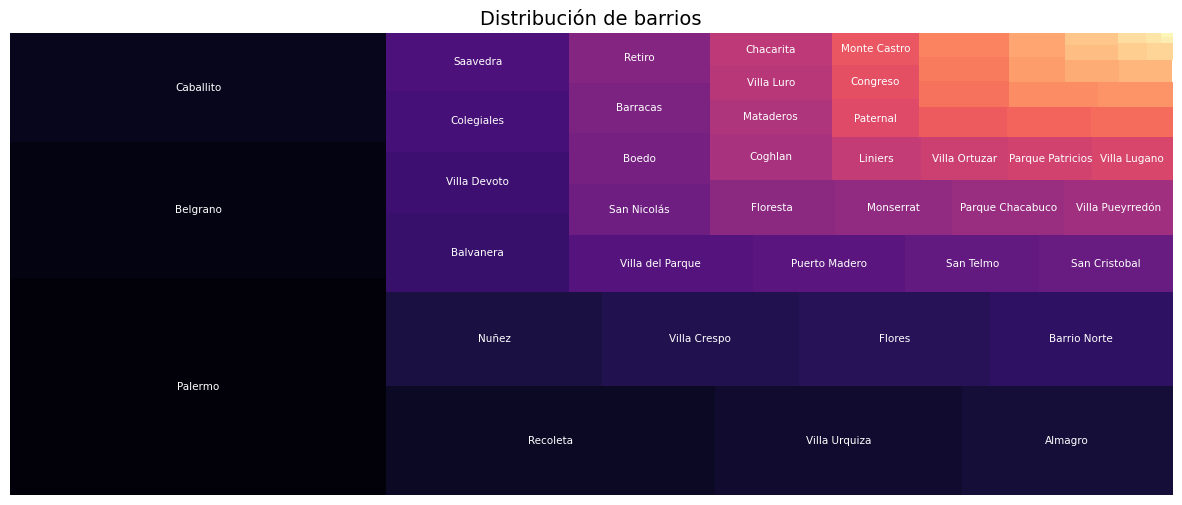

In [322]:
valores = propiedades_train['barrio'].value_counts()
llaves = propiedades_train['barrio'].value_counts().keys()

plt.figure(figsize = (15, 6))
squarify.plot(sizes = valores,
              label = llaves,
              pad = 0.0,
              alpha = 1,
              color = sns.color_palette("magma", len(valores)),
              text_kwargs = {'fontsize': 7.5, 'color': 'white'})

umbral = 375
for index, (size, label) in enumerate(zip(valores, llaves)):
    if size < umbral:
        plt.gca().texts[index].set_text('')

plt.title("Distribución de barrios", fontsize=14, color='black')
plt.axis("off")
plt.show()

Segundo, un CountPlot para observar la proporcion de *tipos* de propiedades y confirmamos, con en el analisis ya realizado, una gran superioridad de *departamentos* por sobre el resto.

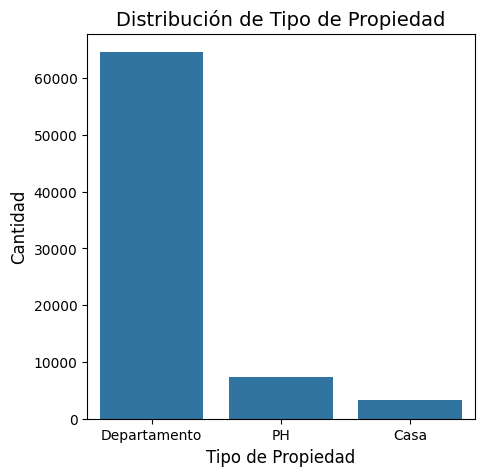

In [323]:
plt.figure(figsize = (5, 5))
sns.countplot(x = 'tipo', data = propiedades_train)

plt.xlabel('Tipo de Propiedad', fontsize = 12)
plt.ylabel('Cantidad', fontsize = 12)
plt.title('Distribución de Tipo de Propiedad', fontsize = 14)

plt.show()

#### Distribucion de Variables Cuantitativas

Tercero, un BoxPlot para observar la distribucion de la cantidad de *ambientes*. Esto tambien sirve para visualizar posibles **outliers**.

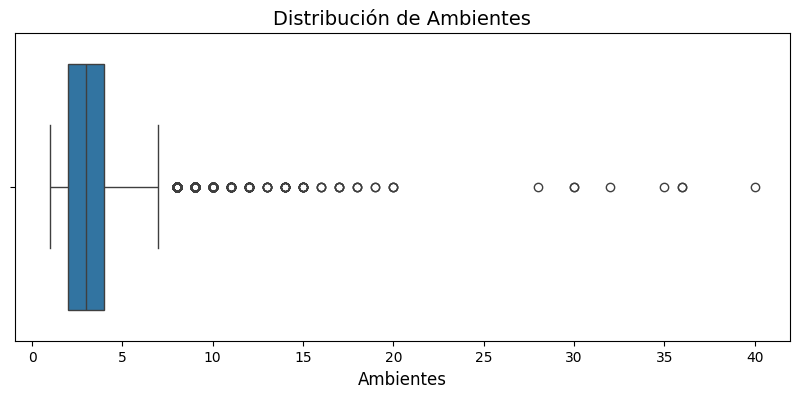

In [324]:
plt.figure(figsize=(10,4))
sns.boxplot(x = "ambientes", data = propiedades_train)

plt.xlabel('Ambientes', fontsize = 12)
plt.title('Distribución de Ambientes', fontsize = 14)

plt.show()

Cuarto, un BoxPlot para observar la distribucion de la *superficie total* de las propiedades. El grafico nos muestra que no solo la variable tiene **outliers**, sino que ademas esos valores no tienen sentido real, por lo que tendremos que trabajar detalladamente mas adelante.

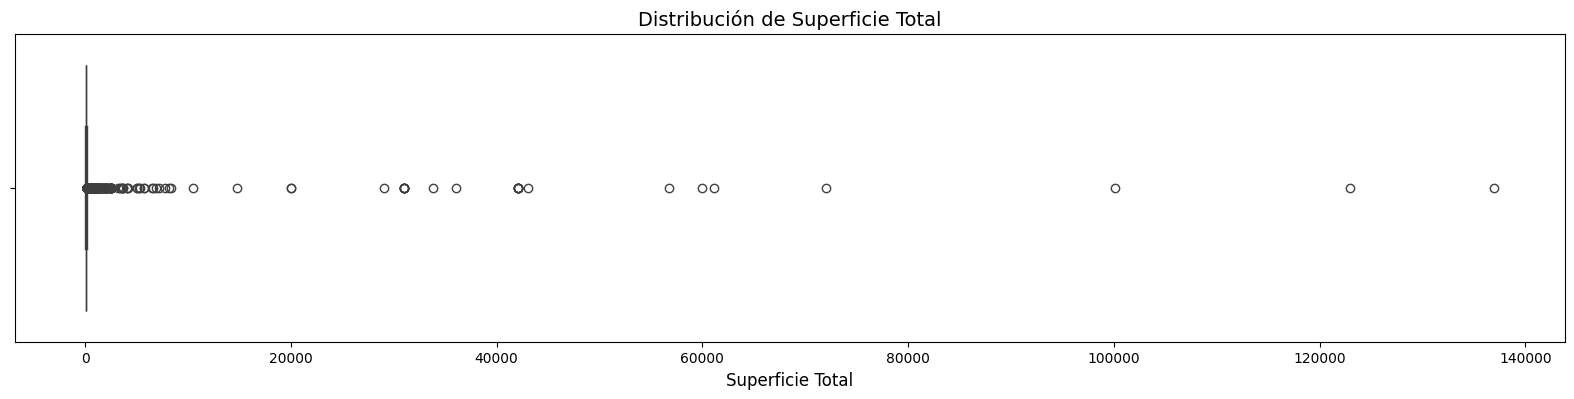

In [325]:
plt.figure(figsize=(20,4))
sns.boxplot(x = "superficie_total", data = propiedades_train)

plt.xlabel('Superficie Total', fontsize = 12)
plt.title('Distribución de Superficie Total', fontsize = 14)

plt.show()

Quinto, un BoxPlot para observar la distribucion del *precio* de las propiedades. El grafico nos muestra que la variable tiene muchos outliers, y a pesar de que esos valores sean posibles, nos da la pauta de que puede haber errores que tendremos que analizar.

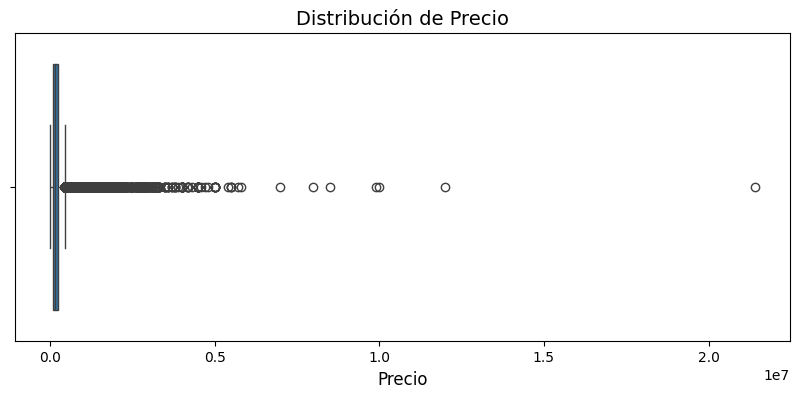

In [326]:
plt.figure(figsize=(10,4))
sns.boxplot(x = "precio", data = propiedades_train)

plt.xlabel('Precio', fontsize = 12)
plt.title('Distribución de Precio', fontsize = 14)

plt.show()

### Correlacion Entre Variables

Con un HeatMap, buscamos rapidamente posibles correlaciones lineales entre las variables cuantitativas mediante la correlacion de Pearson.

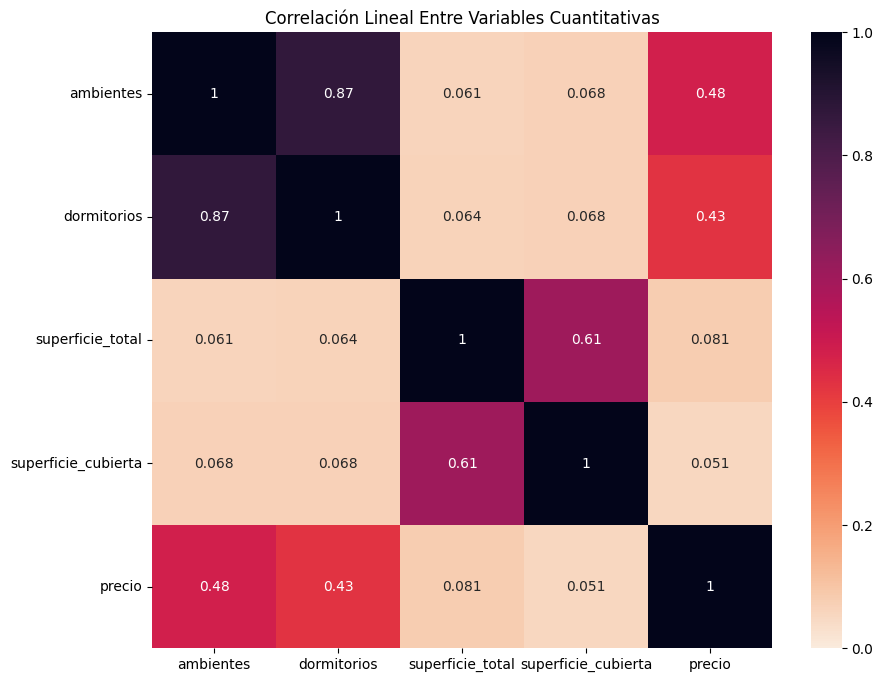

In [327]:
plt.figure(figsize = (10,8))
heatmap_de_propiedades = propiedades_train.drop(['id',
                                                 'latitud',
                                                 'longitud',
                                                 'fecha_inicio',
                                                 'fecha_fin',
                                                 'barrio',
                                                 'subdivision',
                                                 'tipo',
                                                 'nombre'],
                                                axis='columns')
heatmap = sns.heatmap(heatmap_de_propiedades.corr(), annot=True, cmap='rocket_r', vmin=0, vmax=1)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, ha='right');

heatmap.set_title('Correlación Lineal Entre Variables Cuantitativas');

Con el grafico, observamos que la mayoria de las variables no estan relacionadas entre si y aportan mucha informacion al dataset, sin embargo existen algunas relaciones lineales:


*   *Ambientes* y *dormitorios*: Una correlacion evidente ya que un dormitorio es un ambiente, lo que la hace la correlacion lineal mas fuerte del grafico.
*   *Superficie total* y *superficie cubierta*: Otra correlacion evidente ya que la *superficie cubierta* forma parte de la *superficie total*, pero a pesar de esto, no es una correlacion lineal tan fuerte.
*   *Precio* y *ambientes*: Una correlacion logica, que por transitividad se traslada tambien a la correlacion entre el *precio* y los *dormitorios*. De estas tres relaciones destacadas es la mas debil, lo cual no es raro en si, pero si es raro que no tengan una correlacion lineal un poco mas fuerte.

Por ultimo, llama la atencion que distintas variables no tengan una corelacion lineal como el *precio* y la *superficie*, o la *superficie* y el la cantidad de *ambientes*.

Para poder visualizar todas las correlaciones descriptas por el HeatMap, asi tambien como las distribuciones de las variablese en forma de Histogramas, hicimos un pairplot de las variables. En estos graficos observamos la linealidad de las pocas variables correlacionadas que detectamos.

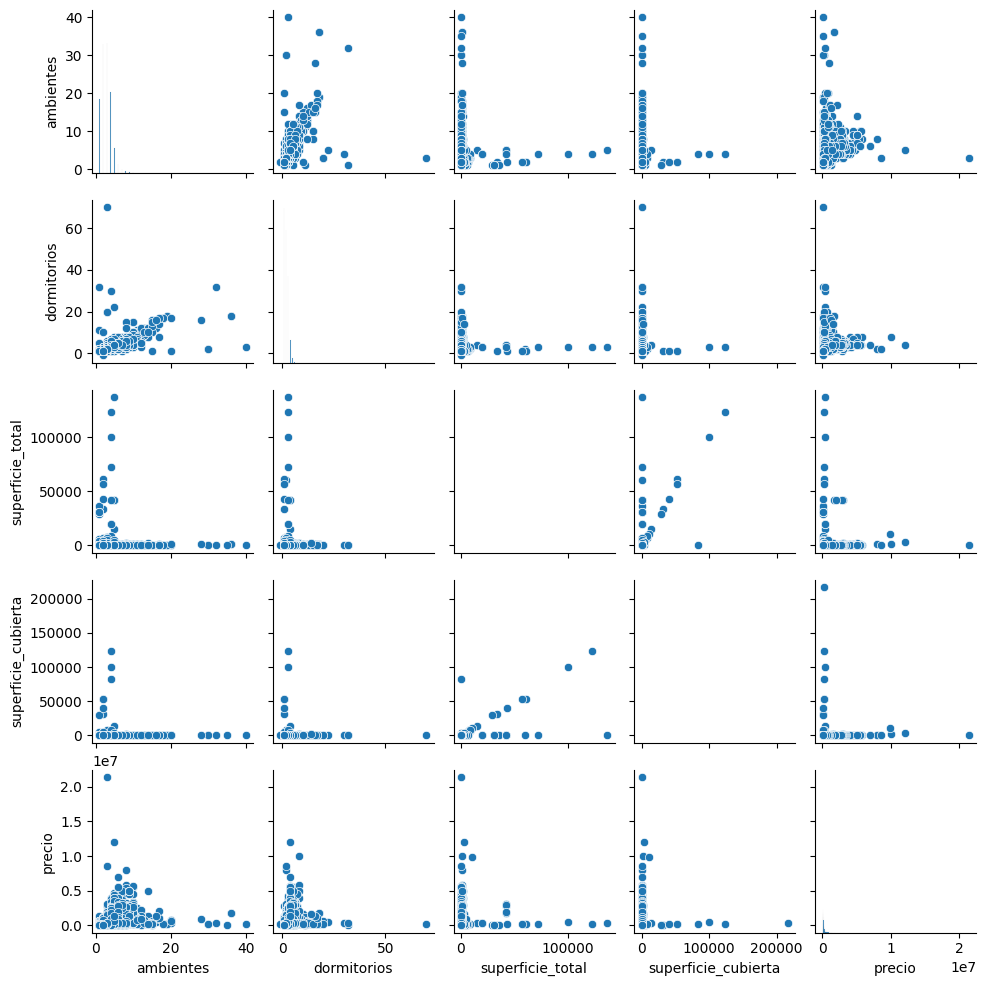

In [328]:
sns.pairplot(heatmap_de_propiedades, height=2)

Ahora, intentamos ver si existe alguna correlacion entre la fecha de inicio y el precio, para intentar confirmar o descartar algun efecto inflacionario en las propiedades. Para esto, trabajamos las *fechas de inicio* por mes y los usamos en un BoxPlot.

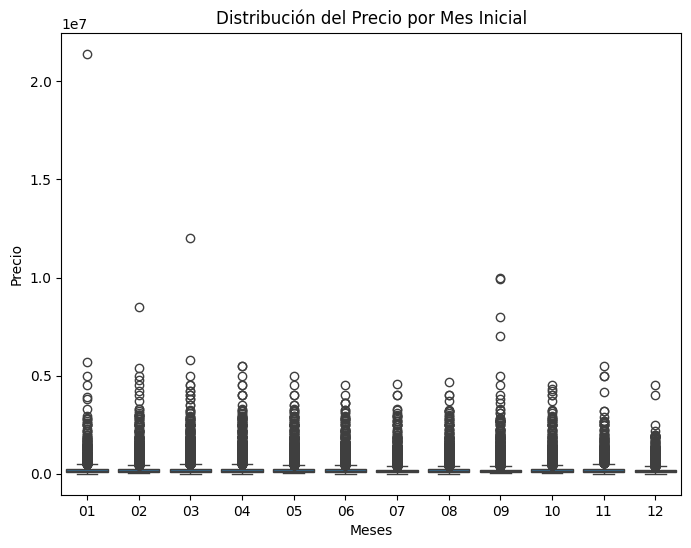

In [329]:
propiedades_por_fecha = propiedades_train.sort_values('fecha_inicio')
meses = propiedades_por_fecha['fecha_inicio'].tolist()
lista_de_meses = []

for mes in meses:
  date = mes.split('-')
  lista_de_meses.append(date[1])

propiedades_por_fecha['mes'] = lista_de_meses

plt.figure(figsize=(8, 6))
sns.boxplot(x = "mes", y = 'precio', data = propiedades_por_fecha)

plt.xlabel('Meses')
plt.ylabel('Precio')
plt.title('Distribución del Precio por Mes Inicial')

plt.show()

Debido a la cantidad de **outliers** en todos los meses, no podemos observar ninguna correlacion entre ambas variables.
Para intentar observar si existe o no dicho efecto, realizamos dos BarPlot trabajando con la mediana y el promedio del *precio*.

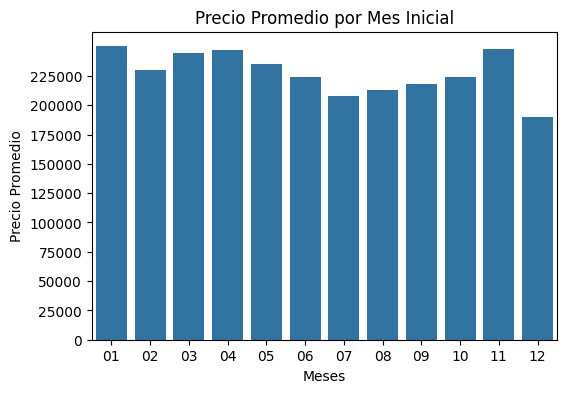

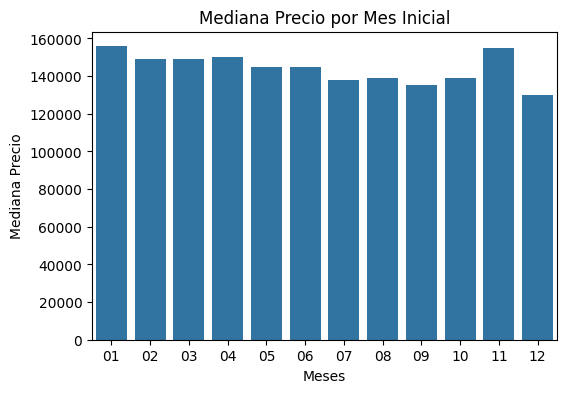

In [330]:
plt.figure(figsize=(6, 4))
propiedades_por_fecha_promedio = propiedades_por_fecha.groupby(['mes'])['precio'].mean().reset_index()
propiedades_por_fecha_promedio.rename(columns = {'precio': 'precio_promedio'}, inplace = True)
sns.barplot(x='mes', y='precio_promedio', data=propiedades_por_fecha_promedio)

plt.yticks(range(0, 225001, 25000))
plt.xlabel('Meses')
plt.ylabel('Precio Promedio')
plt.title('Precio Promedio por Mes Inicial')

plt.show()

plt.figure(figsize=(6, 4))
propiedades_por_fecha_mediana = propiedades_por_fecha.groupby(['mes'])['precio'].median().reset_index()
propiedades_por_fecha_mediana.rename(columns = {'precio': 'precio_mediana'}, inplace = True)
sns.barplot(x='mes', y='precio_mediana', data=propiedades_por_fecha_mediana)

plt.yticks(range(0, 160001, 20000))
plt.xlabel('Meses')
plt.ylabel('Mediana Precio')
plt.title('Mediana Precio por Mes Inicial')

plt.show()

En ambos graficos, sobre todo en el segundo en el cual vemos la mediana del *precio* por mes, observamos una correlacion lineal negativa entre las variables.
Por ende, descartamos temporalmente la posibilidad de un efecto inflacionario en las propiedades, a falta del trabajo de los **outliers** del *precio*.

## Visualizacion de Datos

En esta parte, vamos a observar la relacion entre distintas variables que no tienen un orden especifico.

### Barrios y Otras Variables

Para poder observar las propiedades del datframe en un mapa, realizamos un ScatterPlot sobre un mapa de CABA. Ademas, para identificar los *tipos* de departamento de las propiedades, vamos a pintar los puntos segun esta variable.

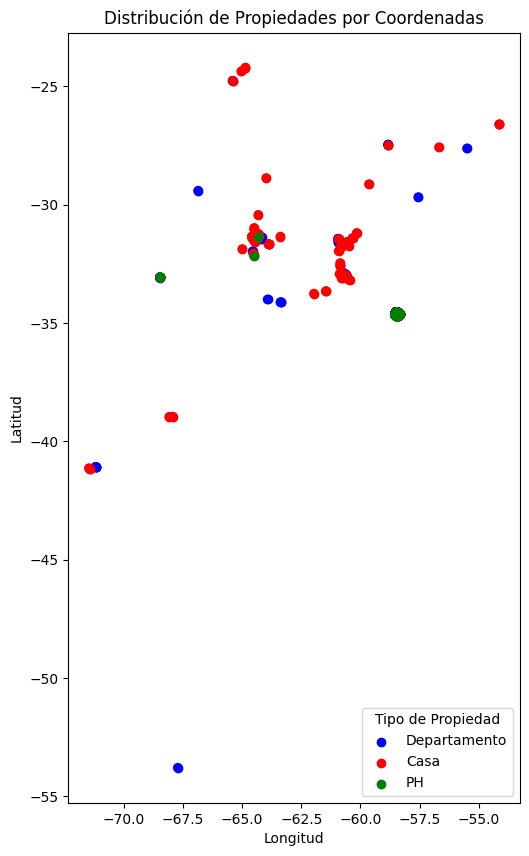

In [331]:
points = propiedades_train[['tipo', 'longitud', 'latitud']].copy()
points.dropna(inplace=True)
points = gp.GeoDataFrame(points, geometry=gp.points_from_xy(points.longitud, points.latitud))
points.reset_index(inplace=True,drop=True)

tipo_colores = {'Departamento': 'blue', 'Casa': 'red', 'PH': 'green'}

fx, ax = plt.subplots(figsize = (10,10))
coordenadas_bsas.plot(ax = ax, column = 'BARRIO', alpha = 0.8)
points.plot(ax=ax, c=points['tipo'].map(tipo_colores), legend=True)

for tipo, color in tipo_colores.items():
    points[points['tipo'] == tipo].plot(ax=ax, color=color, label=tipo)

ax.legend(title='Tipo de Propiedad', loc='lower right')

plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Distribución de Propiedades por Coordenadas')

plt.show()

Observamos que hay varios **outliers** en las coordenadas, y eso hace que se distorsionen las escalas del mapa y por ende, no se llega a ver bien el mapa de CABA.

Para poder visualizar bien el mapa, filtramos los **outliers** y volvemos a realizar el grafico.

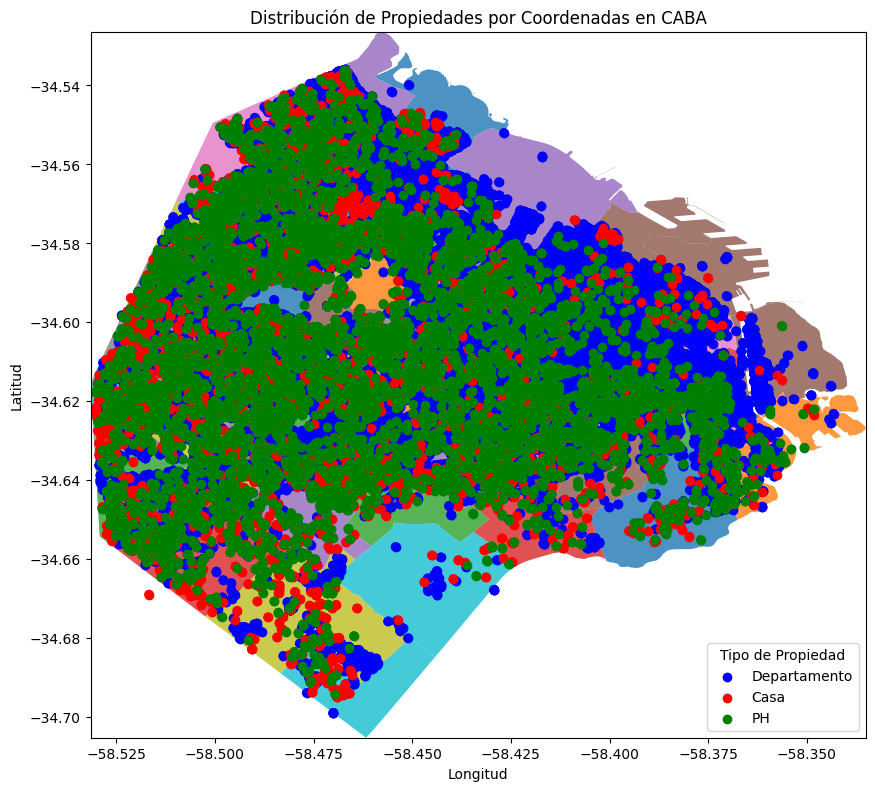

In [332]:
points = propiedades_train[['tipo', 'longitud', 'latitud']].copy()
points.dropna(inplace=True)
points = gp.GeoDataFrame(points, geometry=gp.points_from_xy(points.longitud, points.latitud))
points.reset_index(inplace=True,drop=True)

tipo_colores = {'Departamento': 'blue', 'Casa': 'red', 'PH': 'green'}

fx, ax = plt.subplots(figsize = (10,10))
coordenadas_bsas.plot(ax = ax, column = 'BARRIO', alpha = 0.8)
points.plot(ax=ax, c=points['tipo'].map(tipo_colores), legend=True)

plt.xlim(coordenadas_bsas.total_bounds[0], coordenadas_bsas.total_bounds[2])
plt.ylim(coordenadas_bsas.total_bounds[1], coordenadas_bsas.total_bounds[3])

for tipo, color in tipo_colores.items():
    points[points['tipo'] == tipo].plot(ax=ax, color=color, label=tipo)

ax.legend(title='Tipo de Propiedad', loc='lower right')

plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Distribución de Propiedades por Coordenadas en CABA')

plt.show()

Primero, relacionamos mediante BoxPlots los *barrios* con la cantidad de *ambientes*, la cantidad de *dormitorios*, la *superficie total*, la *superficie cubierta*, y el *precio*.

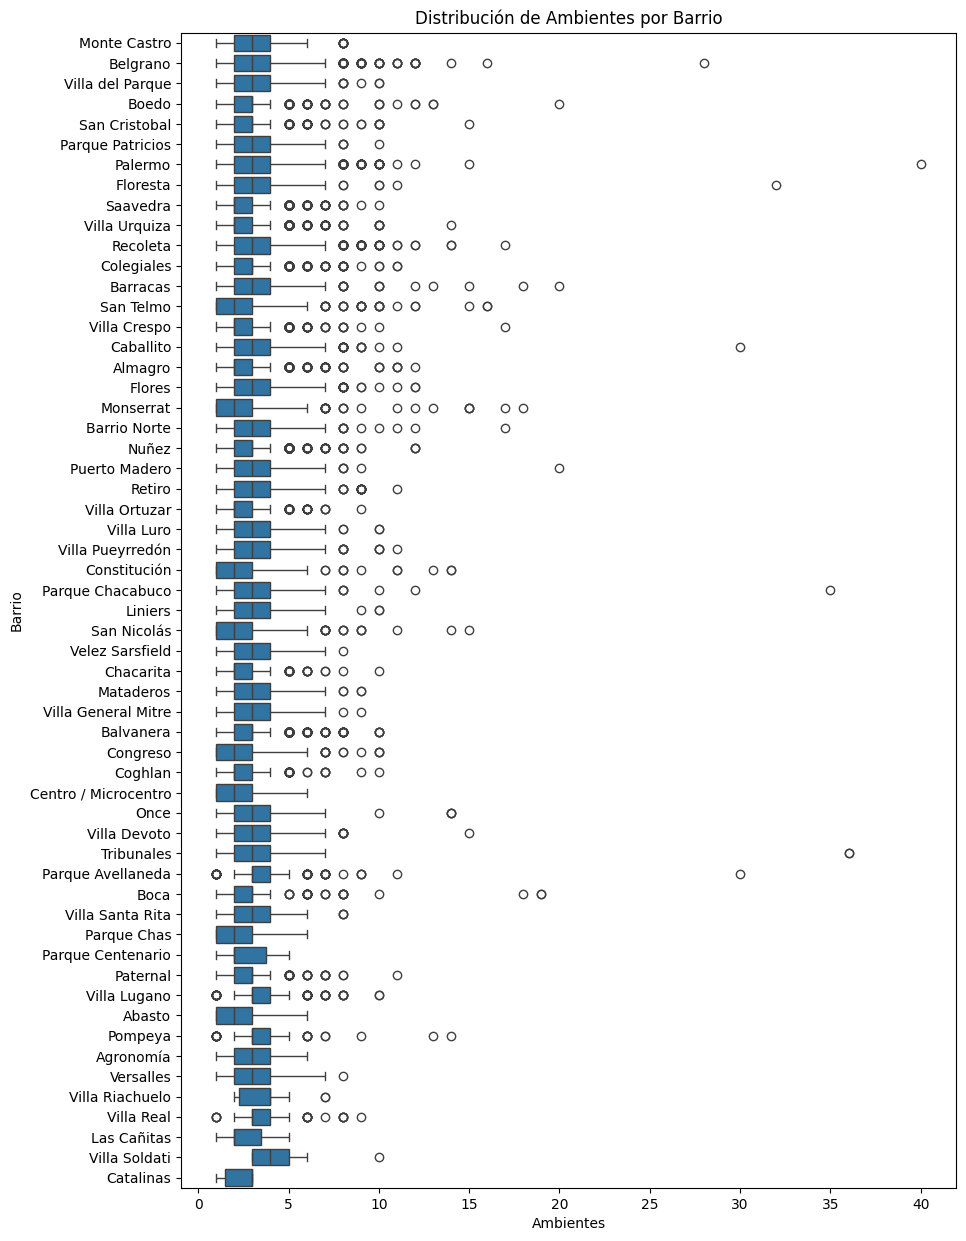

In [333]:
plt.figure(figsize = (10,15))
sns.boxplot(y = 'barrio', x = 'ambientes', data = propiedades_train)

plt.ylabel('Barrio')
plt.xlabel('Ambientes')
plt.title('Distribución de Ambientes por Barrio')

plt.show()

Con este grafico podemos visualizar la distribucion de *ambientes* por *barrio* y ademas, nos permite comparar su distribucion, y en especial los **outliers**, con el siguiente grafico de *dormitorios* por *barrio*.

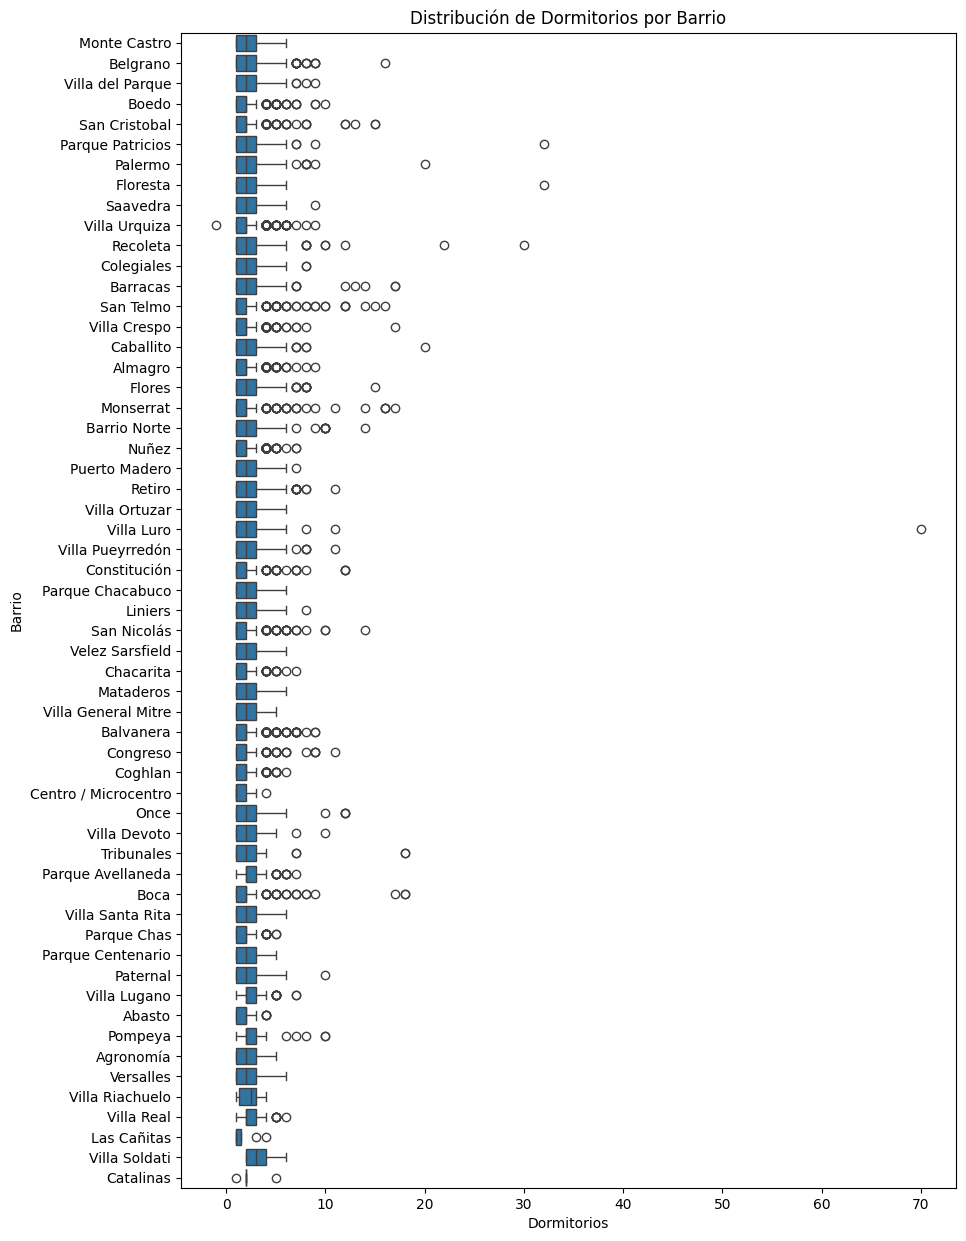

In [334]:
plt.figure(figsize = (10,15))
sns.boxplot(y = 'barrio', x = 'dormitorios', data = propiedades_train)

plt.ylabel('Barrio')
plt.xlabel('Dormitorios')
plt.title('Distribución de Dormitorios por Barrio')

plt.show()

Comparando este segundo grafico con el anterior, vemos que existen **outliers** que directamente, no tienen sentido. Por ejemplo, segun ambos graficos existe una propiedad con 70 dormitorios, cuando no hay ninguna propiedad que supere los 40 ambientes.

Con esto confirmamos no solo la presencia de **outliers**, sino tambien de errores que carecen de sentido ya que no son posibles.

Con el mismo concepto, comparamos los graficos de *barrios* y *superficie total*, con el de *barrios* y *superficie cubierta*.

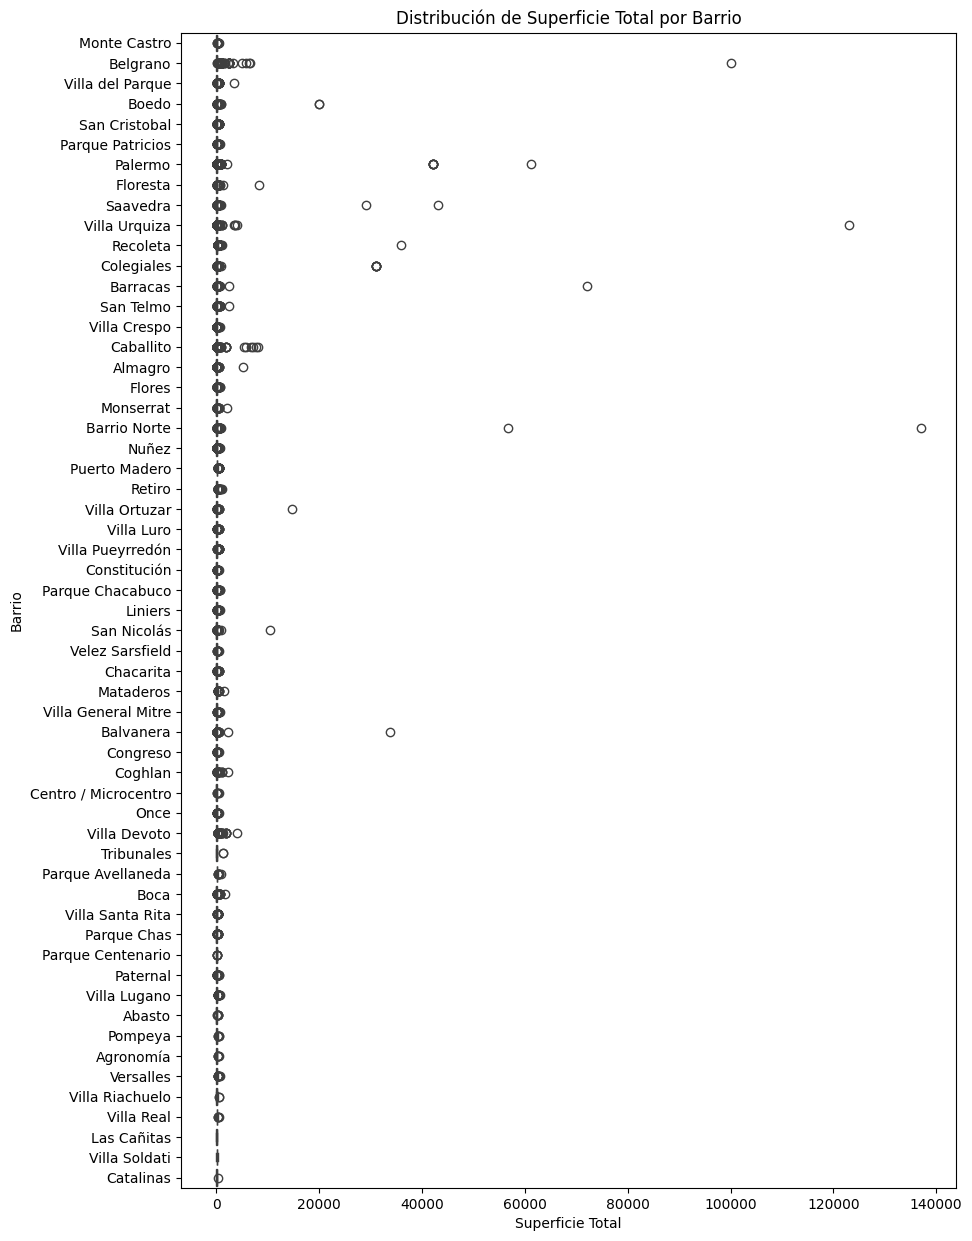

In [335]:
plt.figure(figsize = (10,15))
sns.boxplot(y = 'barrio', x = 'superficie_total', data = propiedades_train)

plt.ylabel('Barrio')
plt.xlabel('Superficie Total')
plt.title('Distribución de Superficie Total por Barrio')

plt.show()

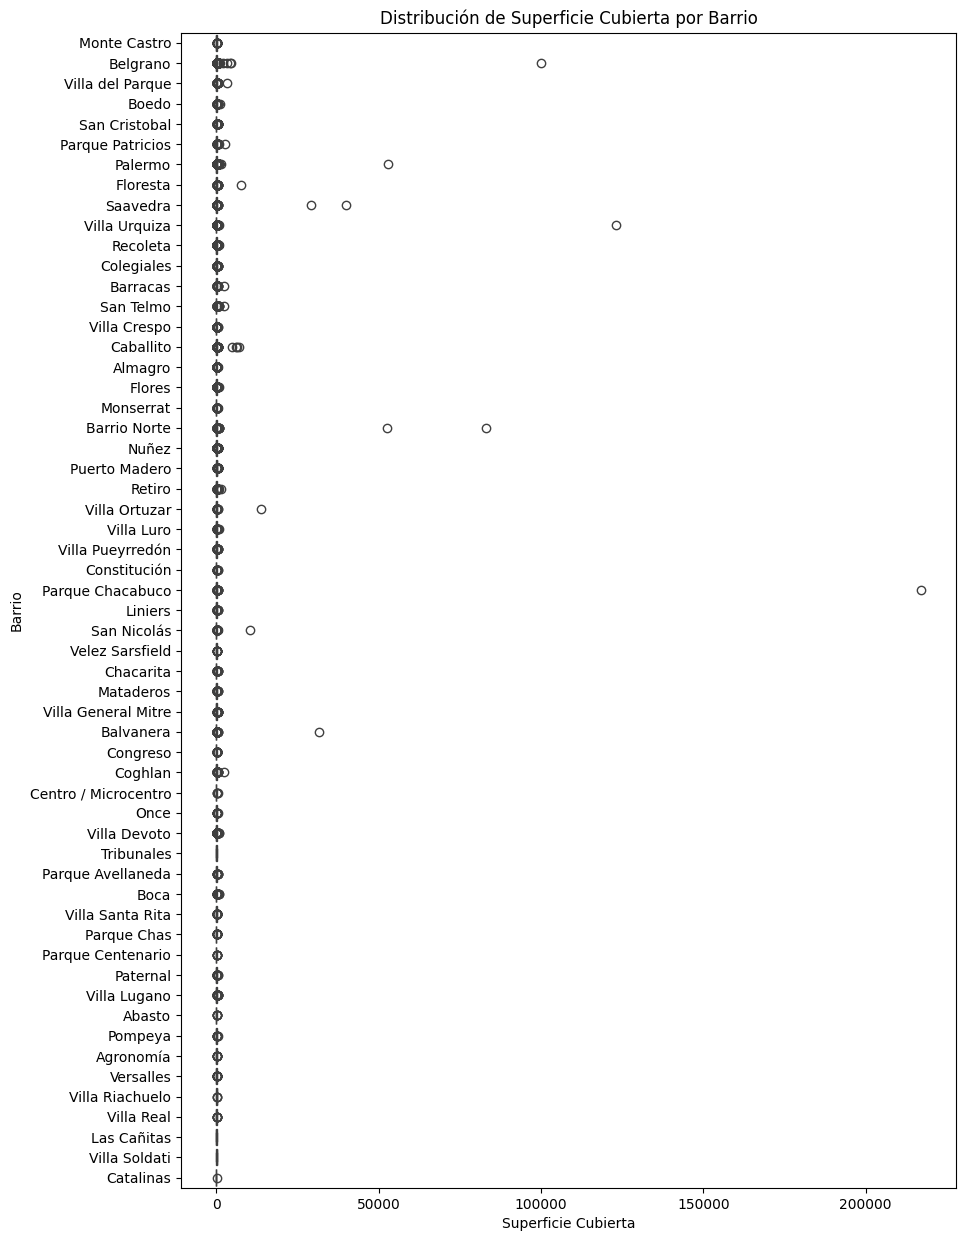

In [336]:
plt.figure(figsize = (10,15))
sns.boxplot(y = 'barrio', x = 'superficie_cubierta', data = propiedades_train)

plt.ylabel('Barrio')
plt.xlabel('Superficie Cubierta')
plt.title('Distribución de Superficie Cubierta por Barrio')

plt.show()

Con estos ultimos dos graficos, tenemos el mismo escenario que con los primeros dos. No es posible que exista una propiedad con mas *superfice cubierta* que *superficie total*, ya que tambien carece de sentido.

Por lo tanto, tambien podemos confirmar que ademas de outliers existen errores en las variables de *superficie total* y *superficie cubierta*.

Por ultimo, realizamos este BoxPlot de *precio* por *barrio* para observar los **outliers** existentes.

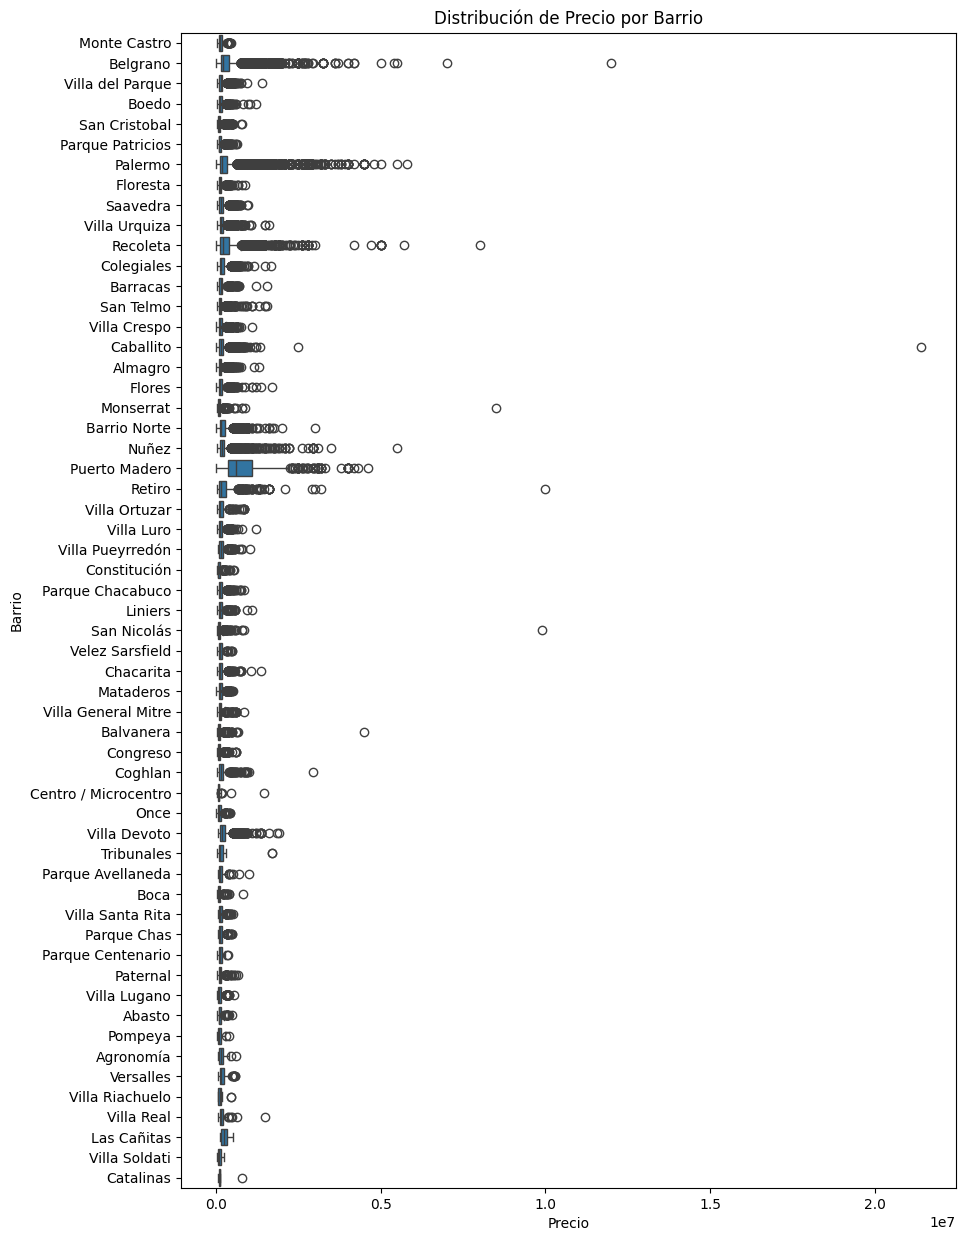

In [337]:
plt.figure(figsize = (10,15))
sns.boxplot(y = 'barrio', x = 'precio', data = propiedades_train)

plt.ylabel('Barrio')
plt.xlabel('Precio')
plt.title('Distribución de Precio por Barrio')

plt.show()

Ademas observamos que, a pesar de estos **outliers**, hay algunos barrios que se distinguen del resto ya que su rango intercuartilico se separa mas del 0, particularmente *Puerto Madero*.

### Subdivisiones y Otras Variables

Segundo, relacionamos mediante BoxPlots las *subdivisiones* con la cantidad de *ambientes*, la *superficie total*, y el *precio*.

Este analisis nos va a servir para determinar la utilidad de la informacion de esta variable, si aporta informacion importante incluso para las propiedades ubicadas en Palermo, o si es irrelevante a que subdivision de Palermo pertenecen.

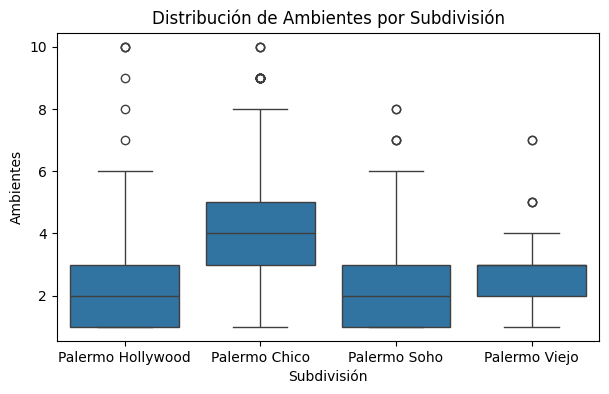

In [338]:
plt.figure(figsize = (7,4))
sns.boxplot(x = 'subdivision', y = 'ambientes', data = propiedades_train)

plt.ylabel('Ambientes')
plt.xlabel('Subdivisión')
plt.title('Distribución de Ambientes por Subdivisión')

plt.show()

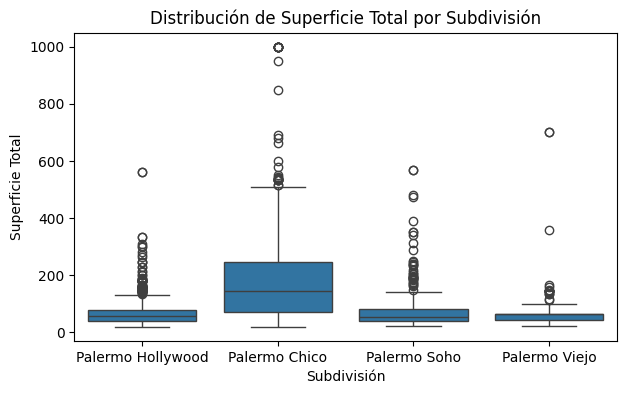

In [339]:
plt.figure(figsize = (7,4))
sns.boxplot(x = 'subdivision', y = 'superficie_total', data = propiedades_train)

plt.ylabel('Superficie Total')
plt.xlabel('Subdivisión')
plt.title('Distribución de Superficie Total por Subdivisión')

plt.show()

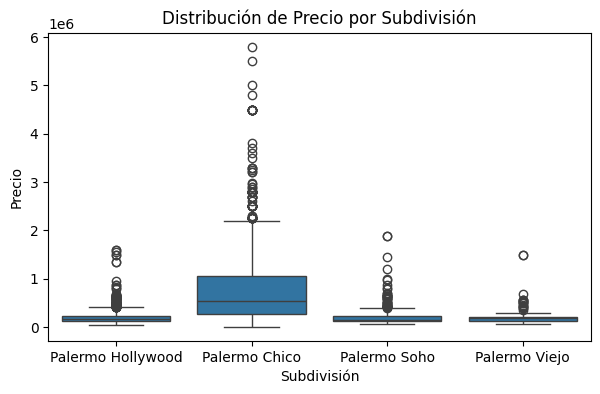

In [340]:
plt.figure(figsize = (7,4))
sns.boxplot(x = 'subdivision', y = 'precio', data = propiedades_train)

plt.ylabel('Precio')
plt.xlabel('Subdivisión')
plt.title('Distribución de Precio por Subdivisión')

plt.show()

A pesar de que la mayoria de propiedades de Palermo no tiene subdivision, vemos que las propiedades de Palermo Chico se destacan en todas las categorias por sobre las demas, que tienen valores similares.

## Datos Faltantes o Erroneos


En este apartado analizamos la presencia de datos faltantes en forma de datos nulos, y tambien todos los casos posibles de datos erroneos como por ejemplo datos negativos. En base a lo que encontremos, tomamos una decision que puede ser imputar una correccion, o simplemente eliminar esos datos.

Una vez terminado este proceso, vamos a reanalizar las distribuciones de las variables para comparar las diferencias con los datos anteriores a las siguientes imputaciones.

### Imputacion

#### Analisis de Datos Nulos

Para empezar, analizamos y graficamos el porcentaje de datos nulos por columna en el dataframe.

In [341]:
porcentajes = (propiedades_train.isna().sum() / len(propiedades_train)) * 100
cantidades_de_nan = propiedades_train.isna().sum()
claves = porcentajes.keys().tolist()
valores = porcentajes.values.tolist()
datos = {'variable': claves, 'porcentaje': valores , 'cantidad': cantidades_de_nan}
porcentajes = pd.DataFrame(data = datos)
porcentajes

,variable,porcentaje,cantidad
id,id,0.000000,0
fecha_inicio,fecha_inicio,0.000000,0
fecha_fin,fecha_fin,0.000000,0
latitud,latitud,3.950981,2979
longitud,longitud,3.950981,2979
barrio,barrio,0.432366,326
subdivision,subdivision,96.193583,72529
tipo,tipo,0.000000,0
ambientes,ambientes,1.119378,844
dormitorios,dormitorios,11.673895,8802


Text(0.5, 1.0, 'Porcentaje de Nulos por Variable')

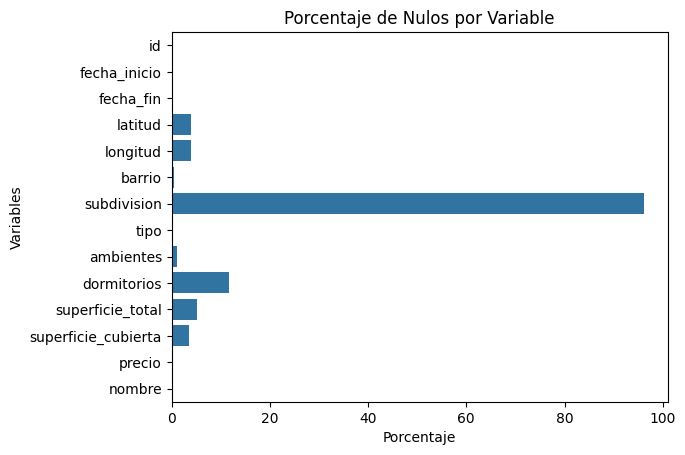

In [342]:
barplot = sns.barplot(x='porcentaje', y='variable', data=porcentajes)

barplot.set_xlabel('Porcentaje')
barplot.set_ylabel('Variables')
plt.title('Porcentaje de Nulos por Variable')

Repetimos el analisis, esta vez para visualizar el porcentaje de datos nulos por fila del dataframe, es decir, para ver cuantos nulos por fila hay.

In [343]:
propiedades_train.reset_index(inplace=True, drop=True)
propiedades_filas_nulas = propiedades_train.isna()
nulos = pd.Series(dtype=int, index=range(75399))

for indice, fila in propiedades_filas_nulas.iterrows():
  contador_nulos = 0
  for nombre_columna, valor in fila.items():
    if valor:
      contador_nulos += 1
  nulos[indice] = contador_nulos

propiedades_filas_nulas['nulos'] = nulos
propiedades_train['nulos'] = propiedades_filas_nulas['nulos']

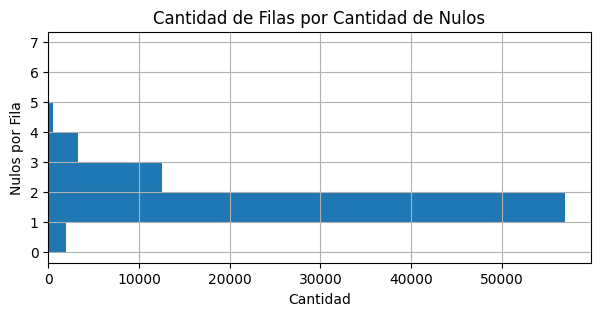

In [344]:
plt.figure(figsize=(7,3))
propiedades_train['nulos'].hist(orientation = "horizontal", bins = 7)

plt.xlabel('Cantidad')
plt.ylabel('Nulos por Fila')
plt.title('Cantidad de Filas por Cantidad de Nulos')

plt.show()

#### Subdivision de Barrios

En base a los analisis de cantidad de datos nulos que acabamos de realizar, y a los analisis de los datos de la variable *subdivision* que realizamos en el apartado anterior, notamos que la mayoria de datos de la variable son nulos, y los datos que no son nulos son aquellos que pertenecen a propiedades ubicadas en Palermo.

In [345]:
propiedades_de_palermo = propiedades_train[propiedades_train['barrio'] == 'Palermo']
propiedades_de_palermo.shape

(11397, 15)

In [346]:
propiedades_de_palermo['subdivision'].isna().sum()

8527

Pero el problema es que de las 11397 propiedades ubicadas en Palermo, 8527 poseen un dato nulo en su *subdivision*. Debido a la complejidad de rellenar estos datos, ya que no tenemos poseemos en nuestro dataset o en otros datasets los datos necesarios, y a que no perdemos informacion de ninguna propiedad y las podemos ubicar a todas en Palermo, decidimos eliminar la columna *subdivision*.

In [347]:
propiedades_train.drop(['subdivision'], axis=1, inplace=True)

#### Barrios y Coordenadas

Ahora analizamos las propiedades que posean coordenadas nulas.

In [348]:
propiedades_train.shape

(75399, 14)

In [349]:
propiedades_train[propiedades_train['barrio'].isna() &
                  propiedades_train['latitud'].isna() &
                  propiedades_train['longitud'].isna()].shape

(132, 14)

Observamos que la cantidad de propiedades que contienen *latitud*, *longitud* y *barrio* nulos a la vez, es de 132. Esta magnitud comparada con el total de registros que es 75399, y por lo tanto las consideramos despreciable y las eliminamos.

In [350]:
propiedades_sin_ubicacion_nula = propiedades_train[~(propiedades_train['barrio'].isna() &
                                                     propiedades_train['latitud'].isna() &
                                                     propiedades_train['longitud'].isna())]

propiedades_sin_ubicacion_nula[propiedades_sin_ubicacion_nula['barrio'].isna() &
                               propiedades_sin_ubicacion_nula['latitud'].isna() &
                               propiedades_sin_ubicacion_nula['longitud'].isna()].shape

(0, 14)

In [351]:
propiedades_sin_ubicacion_nula.shape

(75267, 14)

Ahora, ya sabiendo que no existen propiedades con ningun dato de su ubicacion, buscamos propiedades que posean sus coordenadas pero no el barrio donde se ubican.

In [352]:
propiedades_sin_ubicacion_nula[propiedades_sin_ubicacion_nula['barrio'].isna()].shape

(194, 14)

Observamos que la cantidad de registros que poseen *barrio* nulo pero que disponen de *latitud* y *longitud* son 194, suma que tambien consideraremos despreciable.

In [353]:
propiedades_sin_barrio_nulo = propiedades_sin_ubicacion_nula[~(propiedades_sin_ubicacion_nula['barrio'].isna())]
propiedades_sin_barrio_nulo.shape

(75073, 14)

Por ultimo, buscamos las propiedades con coordenadas nulas.

In [354]:
propiedades_sin_barrio_nulo[propiedades_sin_barrio_nulo['latitud'].isna() & propiedades_sin_barrio_nulo['longitud'].isna()].shape

(2847, 14)

Vemos que restan 2847 registros que no poseen ni *latitud* ni *longitud*, pero que si poseen *barrio*, y para rellenar los datos imputaremos las coordenadas mediante un geolocalizador.

In [355]:
coordenadas_bsas["centroide_x"] = coordenadas_bsas["geometry"].centroid.x
coordenadas_bsas["centroide_y"] = coordenadas_bsas["geometry"].centroid.y
propiedades_sin_barrio_nulo['barrio'].unique()

<ipython-input-355-2e54f8f6f133>:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  coordenadas_bsas["centroide_x"] = coordenadas_bsas["geometry"].centroid.x
<ipython-input-355-2e54f8f6f133>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  coordenadas_bsas["centroide_y"] = coordenadas_bsas["geometry"].centroid.y


array(['Monte Castro', 'Belgrano', 'Villa del Parque', 'Boedo',
       'San Cristobal', 'Parque Patricios', 'Palermo', 'Floresta',
       'Saavedra', 'Villa Urquiza', 'Recoleta', 'Colegiales', 'Barracas',
       'San Telmo', 'Villa Crespo', 'Caballito', 'Almagro', 'Flores',
       'Monserrat', 'Barrio Norte', 'Nuñez', 'Puerto Madero', 'Retiro',
       'Villa Ortuzar', 'Villa Luro', 'Villa Pueyrredón', 'Constitución',
       'Parque Chacabuco', 'Liniers', 'San Nicolás', 'Velez Sarsfield',
       'Chacarita', 'Mataderos', 'Villa General Mitre', 'Balvanera',
       'Congreso', 'Coghlan', 'Centro / Microcentro', 'Once',
       'Villa Devoto', 'Tribunales', 'Parque Avellaneda', 'Boca',
       'Villa Santa Rita', 'Parque Chas', 'Parque Centenario', 'Paternal',
       'Villa Lugano', 'Abasto', 'Pompeya', 'Agronomía', 'Versalles',
       'Villa Riachuelo', 'Villa Real', 'Las Cañitas', 'Villa Soldati',
       'Catalinas'], dtype=object)

Antes de rellenar las coordenadas nulas, trabajamos el dataframe que contiene las coordenadas de los barrios de CABA para que sus barrios coincidan con nuestro dataframe.

In [356]:
coordenadas_bsas.loc[coordenadas_bsas['BARRIO'] == 'CONSTITUCION', 'BARRIO'] = 'CONSTITUCIÓN'
coordenadas_bsas.loc[coordenadas_bsas['BARRIO'] == 'SAN NICOLAS', 'BARRIO'] = 'SAN NICOLÁS'
coordenadas_bsas.loc[coordenadas_bsas['BARRIO'] == 'VILLA PUEYRREDON', 'BARRIO'] = 'VILLA PUEYRREDÓN'
coordenadas_bsas.loc[coordenadas_bsas['BARRIO'] == 'AGRONOMIA', 'BARRIO'] = 'AGRONOMÍA'
coordenadas_bsas.loc[coordenadas_bsas['BARRIO'] == 'NUEVA POMPEYA', 'BARRIO'] = 'POMPEYA'
coordenadas_bsas.loc[coordenadas_bsas['BARRIO'] == 'VILLA GRAL. MITRE', 'BARRIO'] = 'VILLA GENERAL MITRE'

propiedades_sin_barrio_nulo.loc[propiedades_sin_barrio_nulo['barrio'] == 'Once', 'barrio'] = 'Balvanera'
propiedades_sin_barrio_nulo.loc[propiedades_sin_barrio_nulo['barrio'] == 'Abasto', 'barrio'] = 'Balvanera'
propiedades_sin_barrio_nulo.loc[propiedades_sin_barrio_nulo['barrio'] == 'Congreso', 'barrio'] = 'Balvanera'
propiedades_sin_barrio_nulo.loc[propiedades_sin_barrio_nulo['barrio'] == 'Barrio Norte', 'barrio'] = 'Recoleta'
propiedades_sin_barrio_nulo.loc[propiedades_sin_barrio_nulo['barrio'] == 'Parque Centenario', 'barrio'] = 'Caballito'
propiedades_sin_barrio_nulo.loc[propiedades_sin_barrio_nulo['barrio'] == 'Las Cañitas', 'barrio'] = 'Palermo'
propiedades_sin_barrio_nulo.loc[propiedades_sin_barrio_nulo['barrio'] == 'Tribunales', 'barrio'] = 'San Nicolás'
propiedades_sin_barrio_nulo.loc[propiedades_sin_barrio_nulo['barrio'] == 'Centro / Microcentro', 'barrio'] = 'San Nicolás'

In [357]:
propiedades_sin_latitud = propiedades_sin_barrio_nulo[(propiedades_sin_barrio_nulo['latitud'].isna()) & (propiedades_sin_barrio_nulo['id'])]
ids = propiedades_sin_latitud['id']

for id in ids:
  barrio = propiedades_sin_latitud.loc[propiedades_sin_latitud['id'] == id, 'barrio'].values[0]
  if not coordenadas_bsas.loc[coordenadas_bsas.BARRIO == barrio.upper()].empty:
    centroide_x = coordenadas_bsas.loc[coordenadas_bsas.BARRIO == barrio.upper(), 'centroide_x'].values[0]
    centroide_y = coordenadas_bsas.loc[coordenadas_bsas.BARRIO == barrio.upper(), 'centroide_y'].values[0]
    propiedades_sin_barrio_nulo.loc[propiedades_sin_barrio_nulo['id'] == id, 'latitud'] = centroide_y
    propiedades_sin_barrio_nulo.loc[propiedades_sin_barrio_nulo['id'] == id, 'longitud'] = centroide_x

propiedades_sin_barrio_nulo.isna().sum()

id                        0
fecha_inicio              0
fecha_fin                 0
latitud                   0
longitud                  0
barrio                    0
tipo                      0
ambientes               780
dormitorios            8701
superficie_total       3832
superficie_cubierta    2684
precio                    0
nombre                    0
nulos                     0
dtype: int64

Revisamos que, una vez hecho el reemplazo, no haya datos nulos en *latitud* y *longitud*.

Ademas de esto, tambien corregimos las posibles propiedades que tengan su barrio, pero que sus coordenadas no esten en CABA.

#### Superficies

Seguimos analizando la cantidad de nulos en *superficie_total* y *superficie_cubierta*.

Primero buscamos casos en donde ambas variables sean nulas simultaneamente.

In [358]:
propiedades_sin_barrio_nulo[propiedades_sin_barrio_nulo['superficie_total'].isna() & propiedades_sin_barrio_nulo['superficie_cubierta'].isna()].shape

(0, 14)

Observamos que no existen dichos casos, y procedemos a buscar casos donde una de las dos es nula y la otra no.

In [359]:
propiedades_sin_barrio_nulo[~(propiedades_sin_barrio_nulo['superficie_total'].isna()) & propiedades_sin_barrio_nulo['superficie_cubierta'].isna()].shape

(2684, 14)

In [360]:
propiedades_sin_barrio_nulo[propiedades_sin_barrio_nulo['superficie_total'].isna() & ~(propiedades_sin_barrio_nulo['superficie_cubierta'].isna())].shape

(3832, 14)

Obtenemos 2684 casos en los que *superficie_total* es nulo, y otros 3832 casos donde *superficie_cubierta* es nulo.

Por lo tanto, procedemos a imputar los datos faltantes de cada columna a través de un metodo multivariado de imputacion con regresion lineal. Para aplicar este metodo, utilizamos los datos de las variables superficie_total, superficie_cubierta, y el tipo, transformando esta ultima a numeros (Departamento = 0, PH = 1, y Casa = 2).

In [361]:
propiedades_sin_barrio_nulo.reset_index(inplace = True, drop = True)

In [362]:
columnas = ["superficie_total", "superficie_cubierta", "tipo"]
df_eliminar_nans = propiedades_sin_barrio_nulo[columnas].copy()
df_eliminar_nans.replace(to_replace={'Departamento': 0, 'PH': 1, 'Casa': 2}, inplace=True)

lr = LinearRegression()
imp = IterativeImputer(estimator = lr,
                       missing_values = np.nan,
                       max_iter = 100,
                       verbose = 0,
                       random_state = 0)
columnas_imputadas = imp.fit_transform(df_eliminar_nans)
superficies_predecidas = pd.DataFrame(columnas_imputadas)
superficies_predecidas.rename(columns = {0: "superficie_total",
                                         1: "superficie_cubierta",
                                         2: "tipo"},
                              inplace = True)

superficies_predecidas['superficie_total'] = round(superficies_predecidas['superficie_total'], 0)
superficies_predecidas['superficie_cubierta'] = round(superficies_predecidas['superficie_cubierta'], 0)

Una vez terminado el metodo, creamos una tabla con los valores de las superficies predecidas.

In [363]:
superficies_predecidas

,superficie_total,superficie_cubierta,tipo
0,51.0,44.0,0.0
1,79.0,66.0,0.0
2,110.0,80.0,0.0
3,97.0,67.0,1.0
4,89.0,89.0,0.0
...,...,...,...
75068,100.0,75.0,0.0
75069,91.0,81.0,0.0
75070,43.0,36.0,0.0
75071,34.0,34.0,0.0


Con la tabla de arriba, reemplazamos los datos nulos con nuestras predicciones.

In [364]:
for i in propiedades_sin_barrio_nulo.index:
  sup_total = superficies_predecidas.at[i, 'superficie_total']
  propiedades_sin_barrio_nulo.at[i, 'superficie_total'] = sup_total
  sup_cubierta = superficies_predecidas.at[i, 'superficie_cubierta']
  propiedades_sin_barrio_nulo.at[i, 'superficie_cubierta'] = sup_cubierta

Como resultado, obtenemos que ya no existen propiedades con *superficie_total* o *superficie_cubierta* nulas.

In [365]:
propiedades_sin_barrio_nulo.isna().sum()

id                        0
fecha_inicio              0
fecha_fin                 0
latitud                   0
longitud                  0
barrio                    0
tipo                      0
ambientes               780
dormitorios            8701
superficie_total          0
superficie_cubierta       0
precio                    0
nombre                    0
nulos                     0
dtype: int64

Antes de seguir con otras variables, vamos a buscar si existen propiedades con mayor *superficie_cubierta* que *superficie_total*, algo que no tiene sentido y no es posible ya que los metros de *superficie_cubierta* estan incluidos en los metros de la *superficie_total*.

In [366]:
propiedades_sin_barrio_nulo[propiedades_sin_barrio_nulo['superficie_total'] < propiedades_sin_barrio_nulo['superficie_cubierta']].shape

(484, 14)

Para lidiar con los 484 casos en los que la condicion anterior se cumple, calculamos el promedio de valores de *superficie_cubierta* de cada grupo de propiedades, agrupadas en base a su *superficie_total*.

In [367]:
promedios_superficie = propiedades_sin_barrio_nulo.groupby('superficie_total')['superficie_cubierta'].mean()
promedios_superficie = promedios_superficie.round(decimals = 0)

Una vez calculado los promedios, reemplazamos los casos en donde se cumpla la condicion con dichos promedios.

In [368]:
for indice, fila in propiedades_sin_barrio_nulo.iterrows():
    if ((fila['superficie_total'] < fila['superficie_cubierta']) and (fila['superficie_total'] >= 20)):
        cant_superficie_total = fila['superficie_total']
        valor = promedios_superficie.loc[cant_superficie_total]
        propiedades_sin_barrio_nulo.at[indice, 'superficie_cubierta'] = round(valor, 0)

Para los casos donde el promedio calculado siga siendo mayor a la *superficie_total*, empatamos el valor de la *superficie_cubierta* al de la *superficie_total*.

In [369]:
propiedades_superficie_cubierta_mayor_que_total = propiedades_sin_barrio_nulo[propiedades_sin_barrio_nulo['superficie_total'] <
                                                                              propiedades_sin_barrio_nulo['superficie_cubierta']]
id_propiedades_superficie_cubierta_mayor_que_total = propiedades_superficie_cubierta_mayor_que_total['id'].tolist()

for id in id_propiedades_superficie_cubierta_mayor_que_total:
  superficie_total = propiedades_sin_barrio_nulo.loc[propiedades_sin_barrio_nulo['id'] == id, 'superficie_total'].values[0]
  propiedades_sin_barrio_nulo.loc[propiedades_sin_barrio_nulo['id'] == id, 'superficie_cubierta'] = superficie_total

In [370]:
propiedades_sin_barrio_nulo[propiedades_sin_barrio_nulo['superficie_total'] < propiedades_sin_barrio_nulo['superficie_cubierta']].shape

(0, 14)

In [371]:
propiedades_sin_barrio_nulo.isna().sum()

id                        0
fecha_inicio              0
fecha_fin                 0
latitud                   0
longitud                  0
barrio                    0
tipo                      0
ambientes               780
dormitorios            8701
superficie_total          0
superficie_cubierta       0
precio                    0
nombre                    0
nulos                     0
dtype: int64

Una vez revisado que ya no existen nulos en ambas variables, y que tampoco existen casos que no son posibles, avanzamos a otras variables.

#### Ambientes y Dormitorios

Para terminar, analizamos las relaciones entre *ambientes* y *dormitorios*.

Cantidad de propiedades con *ambientes* pero con *dormitorios* nulos:

In [372]:
propiedades_sin_barrio_nulo[~(propiedades_sin_barrio_nulo['ambientes'].isna()) & propiedades_sin_barrio_nulo['dormitorios'].isna()].shape

(8360, 14)

Cantidad de Nulos en Ambientes:
Cantidad de propiedades con *dormitorios* pero con *ambientes* nulos:

In [373]:
propiedades_sin_barrio_nulo[propiedades_sin_barrio_nulo['ambientes'].isna() & ~(propiedades_sin_barrio_nulo['dormitorios'].isna())].shape

(439, 14)

Cantidad de propiedades con *ambientes* y *dormitorios* nulos a la vez:

In [374]:
propiedades_sin_barrio_nulo[propiedades_sin_barrio_nulo['ambientes'].isna() & propiedades_sin_barrio_nulo['dormitorios'].isna()].shape

(341, 14)

Observamos que de los 780 registros que tienen *ambientes* nulos, tenemos 341 registros que también tienen *dormitorios* nulos y, por otro lado, 439 que sí poseen datos concretos en *dormitorios*.

En este caso consideramos relevante imputar los datos de ambas columnas, por lo tanto, comenzamos por imputar la columna *ambientes* en las propiedades en donde ambas variables son nulas.

In [375]:
print('Mediana de ambientes:', propiedades_sin_barrio_nulo['ambientes'].median())
print('Promedio de ambientes:', propiedades_sin_barrio_nulo['ambientes'].mean())
print('Moda de ambientes:', propiedades_sin_barrio_nulo['ambientes'].mode())

Mediana de ambientes: 3.0
Promedio de ambientes: 2.824276849770503
Moda de ambientes: 0    3.0
Name: ambientes, dtype: float64


Vemos que la mediana, la moda y el promedio de los valores presentes en la columna *ambientes* tienden a 3.
Por lo tanto imputaremos dicha columna con este último valor.

In [376]:
propiedades_filas_nulas = propiedades_sin_barrio_nulo[['ambientes', 'dormitorios']].isna()
mediana_de_ambientes = propiedades_sin_barrio_nulo['ambientes'].median()

for indice, fila in propiedades_filas_nulas.iterrows():
    if fila['ambientes'] and fila['dormitorios'] and indice in propiedades_sin_barrio_nulo.index:
        propiedades_sin_barrio_nulo.at[indice, 'ambientes'] = mediana_de_ambientes

Observamos la cantidad de propiedades que tienen, tanto ambientes como dormitorios nulos, en simultaneo que deberían ser cero.

In [377]:
propiedades_sin_barrio_nulo[propiedades_sin_barrio_nulo['ambientes'].isna() & propiedades_sin_barrio_nulo['dormitorios'].isna()].shape

(0, 14)

Observamos la cantidad de propiedades que cuentan con dormitorios nulos pero si tienen ambientes aumento, y es la que vamos a rellenar ahora.

In [378]:
propiedades_sin_barrio_nulo[~(propiedades_sin_barrio_nulo['ambientes'].isna()) & propiedades_sin_barrio_nulo['dormitorios'].isna()].shape

(8701, 14)

Para completar los datos nulos, creamos una lista de la media de *dormitorios* segun la cantidad de *ambientes*.

In [379]:
promedios_dormitorios = propiedades_sin_barrio_nulo.groupby('ambientes')['dormitorios'].mean()
promedios_dormitorios = promedios_dormitorios.round(decimals=0)
promedios_dormitorios

ambientes
1.0      1.0
2.0      1.0
3.0      2.0
4.0      3.0
5.0      4.0
6.0      4.0
7.0      4.0
8.0      5.0
9.0      5.0
10.0     6.0
11.0     7.0
12.0     7.0
13.0    10.0
14.0    11.0
15.0    12.0
16.0    14.0
17.0    14.0
18.0    17.0
19.0    18.0
20.0     9.0
28.0    16.0
30.0     2.0
32.0    32.0
35.0     NaN
36.0    18.0
40.0     3.0
Name: dormitorios, dtype: float64

Vemos que hay un registro que tiene 35 ambientes, pero que tiene un promedio nulo, y para no completar el dataframe con un dato nulo, decidimos imputar el promedio a mano con un valor de 17.

In [380]:
promedios_dormitorios[35.0] = 17.0

Recorremos el dataframe imputando los promedios calculados en la lista.

In [381]:
propiedades_filas_nulas = propiedades_sin_barrio_nulo.isna()
for indice, fila in propiedades_filas_nulas.iterrows():
  if (~(fila['ambientes']) & (fila['dormitorios'])):
    ambientes = propiedades_sin_barrio_nulo.at[indice, 'ambientes']
    dormitorios = promedios_dormitorios[ambientes]
    propiedades_sin_barrio_nulo.at[indice, 'dormitorios'] = round(dormitorios, 0)

Una vez terminado, ya no contamos propiedades con *dormitorios* nulos.

In [382]:
propiedades_sin_barrio_nulo['dormitorios'].isna().sum()

0

Y ahora hacemos lo mismo pero al reves. Completamos los ambientes nulos con una lista de promedios de ambientes por cantidad de dormitorios.

In [383]:
propiedades_sin_barrio_nulo['dormitorios'].value_counts()

dormitorios
 1.0     33405
 2.0     22288
 3.0     14298
 4.0      3888
 5.0       754
 6.0       210
 7.0        90
 8.0        45
 9.0        22
 10.0       18
 12.0       14
 11.0        6
 14.0        6
 17.0        6
 16.0        5
 15.0        4
 18.0        4
 32.0        2
 13.0        2
 20.0        2
-1.0         1
 30.0        1
 22.0        1
 70.0        1
Name: count, dtype: int64

Pero antes de crear la lista, vemos que hay un dato que no es coherente ya que no puede haber una cantidad de dormitorios negativa. Para este caso, consideramos a este dato como mal ingresado y suponemos que su valor real es 1, y lo cambiamos manualmente.

In [384]:
propiedades_sin_barrio_nulo = propiedades_sin_barrio_nulo.replace(to_replace = -1.0, value = 1.0)
propiedades_sin_barrio_nulo['dormitorios'].value_counts()

dormitorios
1.0     33406
2.0     22288
3.0     14298
4.0      3888
5.0       754
6.0       210
7.0        90
8.0        45
9.0        22
10.0       18
12.0       14
14.0        6
11.0        6
17.0        6
16.0        5
15.0        4
18.0        4
20.0        2
13.0        2
32.0        2
30.0        1
22.0        1
70.0        1
Name: count, dtype: int64

Aprovechando que encontramos este caso extremo, buscamos si hay propiedades donde la cantidad de *dormitorios* es mayor que la cantidad de *ambientes*. Vemos cuantos casos son:

In [385]:
propiedades_sin_barrio_nulo[propiedades_sin_barrio_nulo['ambientes'] < propiedades_sin_barrio_nulo['dormitorios']].shape

(117, 14)

Observamos que hay 117 propiedades donde estas variables no tienen sentido, y antes de trabajar las propiedades con ambientes nulos, corregimos estos casos con una lista de promedios de ambientes por dormitorios.

In [386]:
promedios_ambientes = propiedades_sin_barrio_nulo.groupby('dormitorios')['ambientes'].mean().round(0)
promedios_ambientes

dormitorios
1.0      2.0
2.0      3.0
3.0      4.0
4.0      5.0
5.0      7.0
6.0      8.0
7.0      9.0
8.0      9.0
9.0     11.0
10.0    11.0
11.0    10.0
12.0    13.0
13.0    15.0
14.0    16.0
15.0    11.0
16.0    18.0
17.0    21.0
18.0    28.0
20.0     3.0
22.0     5.0
30.0     4.0
32.0    16.0
70.0     3.0
Name: ambientes, dtype: float64

Utilizamos la lista creada para cambiar los *ambientes* de las propiedades cuyos *dormitorios* sean mayores.

Cabe destacar que hay promedios en la lista que tambien son menores a la cantidad de *dormitorios* (por ejemplo con 11 *dormitorios* le corresponde un promedio de 10 *ambientes*). Estos casos puntuales seran trabajados mas adelante en la seccion de datos atipicos.

In [387]:
for indice, fila in propiedades_sin_barrio_nulo.iterrows():
  if (fila['ambientes'] < fila['dormitorios']):
    dormitorios = propiedades_sin_barrio_nulo.at[indice, 'dormitorios']
    ambientes = promedios_ambientes[dormitorios]
    propiedades_sin_barrio_nulo.at[indice, 'ambientes'] = ambientes

In [388]:
propiedades_sin_barrio_nulo[propiedades_sin_barrio_nulo['ambientes'] < propiedades_sin_barrio_nulo['dormitorios']].shape

(10, 14)

Reducimos en gran cantidad la cantidad de propiedades con variables invalidas, pero como dijimos antes, quedan casos que vamos a trabajar mas adelante.

Ahora si, aprovechando la lista de promedios que creamos antes, vamos a imputar los *ammbientes* nulos restantes.

In [389]:
propiedades_filas_nulas = propiedades_sin_barrio_nulo.isna()
for indice, fila in propiedades_filas_nulas.iterrows():
  if (fila['ambientes'] & ~(fila['dormitorios'])):
    dormitorios = propiedades_sin_barrio_nulo.at[indice, 'dormitorios']
    ambientes = promedios_ambientes[dormitorios]
    propiedades_sin_barrio_nulo.at[indice, 'ambientes'] = ambientes

Chequeamos que se realizo la imputacion de forma correcta y ya no hay *ambientes* nulos

In [390]:
propiedades_sin_barrio_nulo.isna().sum()

id                     0
fecha_inicio           0
fecha_fin              0
latitud                0
longitud               0
barrio                 0
tipo                   0
ambientes              0
dormitorios            0
superficie_total       0
superficie_cubierta    0
precio                 0
nombre                 0
nulos                  0
dtype: int64

Ademas de ver que ya no hay *ambientes* nulos, confirmamos que ya no hay datos nulos en ninguna variable.

#### Registros Repetidos

Para terminar con esta seccion, vamos a eliminar todos los registros exactamente duplicados (a excepcion de los id que son todos unicos) que existan en el dataframe.

In [391]:
propiedades_sin_barrio_nulo.drop_duplicates(subset=['fecha_inicio',
                                                    'fecha_fin',
                                                    'latitud',
                                                    'longitud',
                                                    'barrio',
                                                    'tipo',
                                                    'ambientes',
                                                    'dormitorios',
                                                    'superficie_total',
                                                    'superficie_cubierta',
                                                    'precio',
                                                    'nombre',
                                                    'nulos'],
                                            keep='last',
                                            ignore_index = True,
                                            inplace = True)

propiedades_sin_barrio_nulo.reset_index(inplace = True, drop = True)

### Distribucion

Con la imputacion de datos faltantes y erroneos terminada, reanalizamos las distribuciones de los datos donde realizamos imputaciones.

Primero, un BoxPlot para observar la distribucion de la cantidad de *ambientes*.

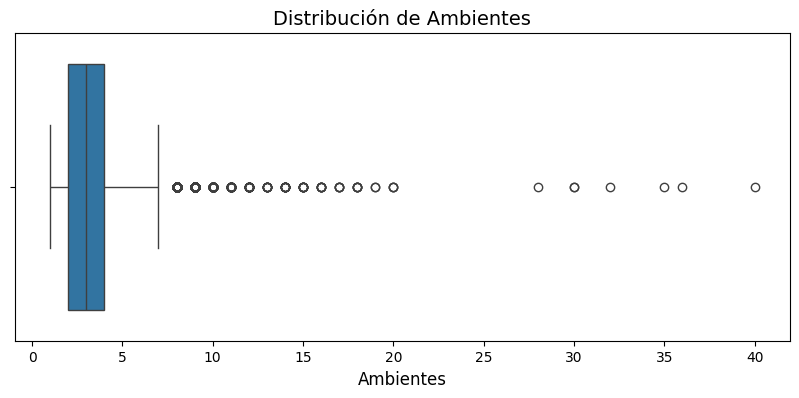

In [392]:
plt.figure(figsize=(10,4))
sns.boxplot(x = "ambientes", data = propiedades_sin_barrio_nulo)

plt.xlabel('Ambientes', fontsize = 12)
plt.title('Distribución de Ambientes', fontsize = 14)

plt.show()

Segundo, un BoxPlot para observar la distribucion de la *superficie total* de las propiedades.

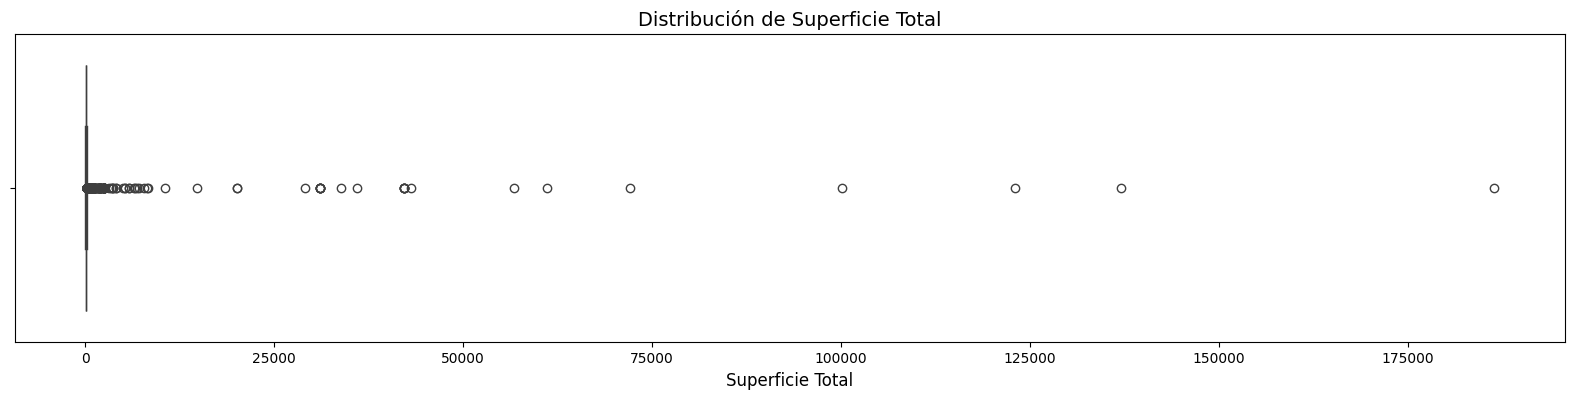

In [393]:
plt.figure(figsize=(20,4))
sns.boxplot(x = "superficie_total", data = propiedades_sin_barrio_nulo)

plt.xlabel('Superficie Total', fontsize = 12)
plt.title('Distribución de Superficie Total', fontsize = 14)

plt.show()

Observamos que en ambos casos, debido a la cantidad de **outliers**, no se notan diferencias en los nuevos graficos.

Una vez trabajados los **outliers** de todas las variables, volveremos a realizar los graficos de distribucion.

## Analisis de Valores Atipicos

Para terminar con la etapa de preprocesamiento, analizamos los outliers o valores atipicos de algunas variables del dataframe.

Por cuestiones obvias, no analizaremos variables con todos datos unicos como el *id*, variables que sabemos que no tienen datos atipicos como *barrio* o *tipo*, variables que no tiene sentido analizar como el *nombre*, o variables que creamos nosotros como los nulos. Ademas, sabemos que dentro de *fecha_fin* hay propiedades con fecha dd-mm-9999 (es decir, con año 9999), en donde consideramos que ese tipo de fechas representa que todavia no fue vendido.

####Coordenadas

A pesar de haber trabajado con las *latitudes* y *longitudes* en la seccion anterior, vamos a buscar propiedades cuyas coordenadas esten cerca de la frontera de CABA pero que aun asi esten afuera.

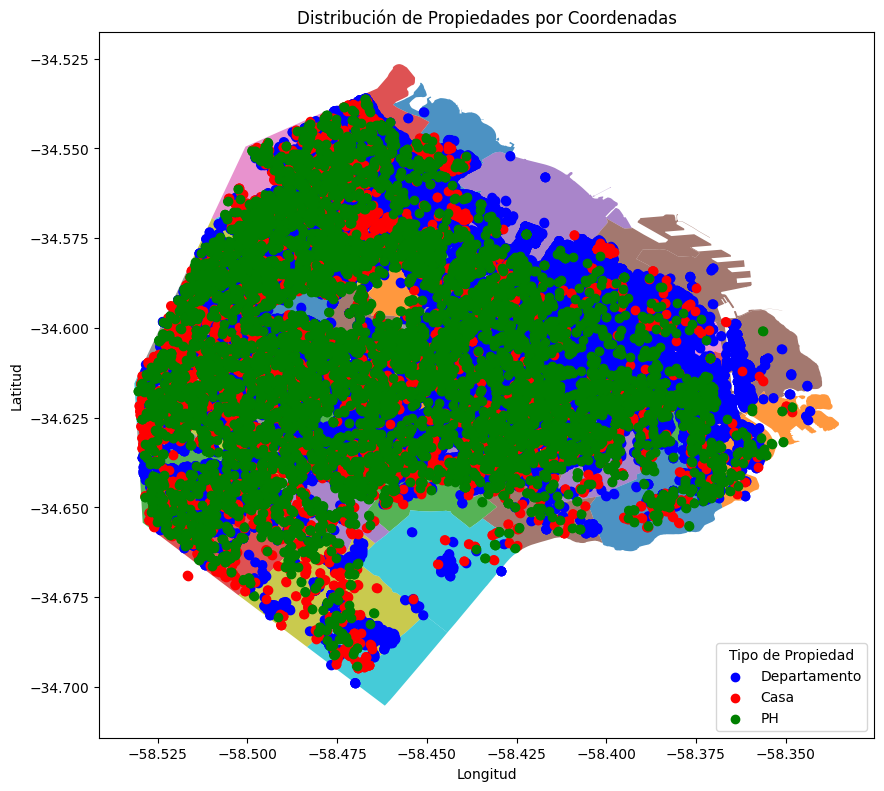

In [394]:
points = propiedades_sin_barrio_nulo[['tipo', 'longitud', 'latitud']].copy()
points.dropna(inplace = True)
points = gp.GeoDataFrame(points, geometry=gp.points_from_xy(points.longitud, points.latitud))
points.reset_index(inplace = True, drop = True)

tipo_colores = {'Departamento': 'blue', 'Casa': 'red', 'PH': 'green'}

fx, ax = plt.subplots(figsize = (10,10))
coordenadas_bsas.plot(ax = ax, column = 'BARRIO', alpha = 0.8)
points.plot(ax = ax, c = points['tipo'].map(tipo_colores), legend=True)

for tipo, color in tipo_colores.items():
    points[points['tipo'] == tipo].plot(ax=ax, color=color, label=tipo)

ax.legend(title='Tipo de Propiedad', loc='lower right')

plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Distribución de Propiedades por Coordenadas')

plt.show()

Observamos en el mapa que hay dos puntos que representan propiedades cuyas coordenadas estan fuera de CABA. Encontramos que detras de esos dos puntos hay cuatro propiedades, una ubicada en el *barrio* de Mataderos, y tres ubicadas en el *barrio* de Flores.

Utilizando los centroides detallados en el dataset de los barrios de CABA, cambiamos las coordenadas de la propiedad de Mataderos.

In [395]:
propiedades_sin_barrio_nulo.loc[36641, 'latitud'] = -34.658373
propiedades_sin_barrio_nulo.loc[36641, 'longitud'] = -58.501737

Con la misma tecnica, cambiamos las coordenadas de las propiedades de Flores.

In [396]:
propiedades_sin_barrio_nulo.loc[9097	, 'latitud'] = -34.636803
propiedades_sin_barrio_nulo.loc[9097	, 'longitud'] = -58.458268

propiedades_sin_barrio_nulo.loc[34344, 'latitud'] = -34.658373
propiedades_sin_barrio_nulo.loc[34344, 'longitud'] = -58.501737

propiedades_sin_barrio_nulo.loc[46219, 'latitud'] = -34.658373
propiedades_sin_barrio_nulo.loc[46219, 'longitud'] = -58.501737

Con las coordenadas corregidas, volvemos a realizar el mapa.

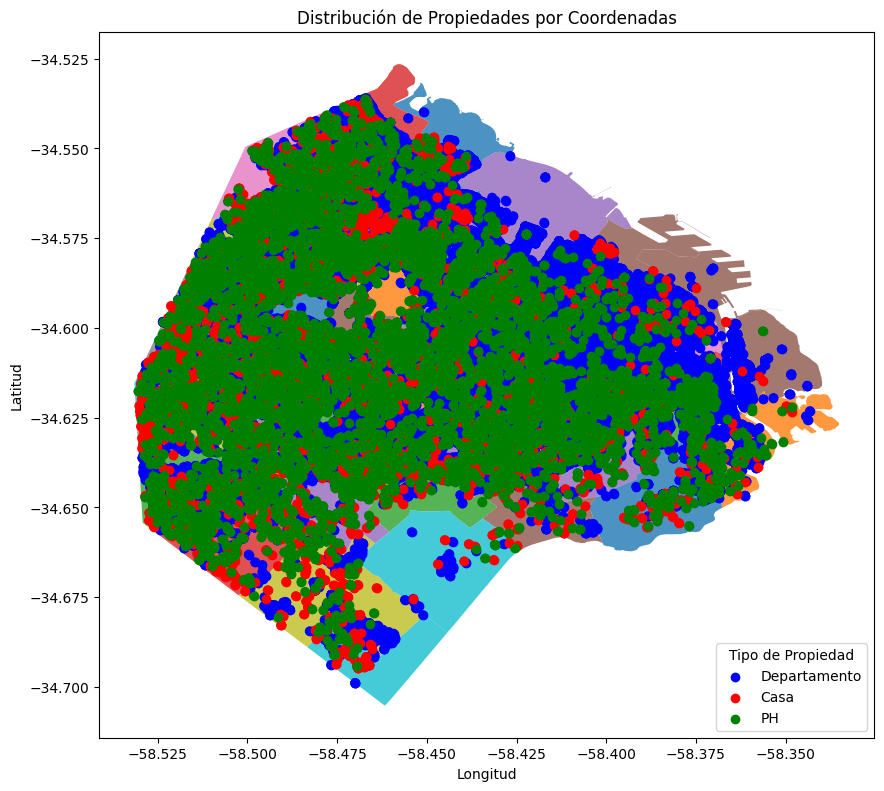

In [397]:
points = propiedades_sin_barrio_nulo[['tipo', 'longitud', 'latitud']].copy()
points.dropna(inplace = True)
points = gp.GeoDataFrame(points, geometry=gp.points_from_xy(points.longitud, points.latitud))
points.reset_index(inplace = True, drop = True)

tipo_colores = {'Departamento': 'blue', 'Casa': 'red', 'PH': 'green'}

fx, ax = plt.subplots(figsize = (10,10))
coordenadas_bsas.plot(ax = ax, column = 'BARRIO', alpha = 0.8)
points.plot(ax = ax, c = points['tipo'].map(tipo_colores), legend=True)

for tipo, color in tipo_colores.items():
    points[points['tipo'] == tipo].plot(ax=ax, color=color, label=tipo)

ax.legend(title='Tipo de Propiedad', loc='lower right')

plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Distribución de Propiedades por Coordenadas')

plt.show()

Vemos que ahora todos los puntos estan ubicados dentro de CABA.

### Ambientes y Dormitorios

En esta parte vamos a analizar *ambientes* y *dormitorios* por separado, aunque como estan fuertemente correlacionadas, vamos a utilizar el analisis y correciones de una para ayudarnos con la otra.

####Ambientes

Para empezar, hacemos un ScatterPlot de *ambientes* y *dormitorios* donde podemos visualizar todos los registros con ambas variables.

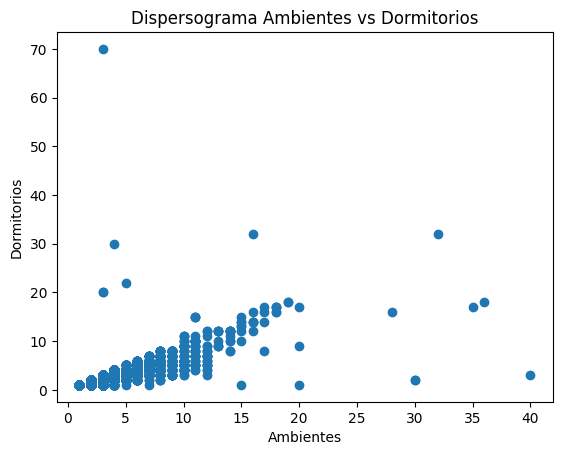

In [398]:
plt.scatter(propiedades_sin_barrio_nulo['ambientes'], propiedades_sin_barrio_nulo['dormitorios'])

plt.title("Dispersograma Ambientes vs Dormitorios")
plt.xlabel("Ambientes")
plt.ylabel("Dormitorios")

plt.show()

Lo primero que observamos es que la mayoria de propiedades tienen entre 1 y 12 *ambientes*, y al ser mayoria, es el grupo de propiedades con valores tipicos. Al considerarlos valores tipicos, este va a ser el umbral de analisis, es decir, no vamos a analizar propiedades con 12 *ambientes* o menos.

Despues vemos que hay un grupo un poco mas reducido que tiene entre 13 y 20 *ambientes*, y son outliers que eventualmente analizaremos, pero que siguen siendo valores verosimiles.

Al final hay otro grupo de puntos menos concentrados y de menor cantidad, que va de 28 *ambientes* en adelante, y que ya tiene valores menos verosimiles. Eso no quiere decir que no puedan ser posibles en absoluto, ni que vayan a ser eliminados, pero son los primeros que vamos a analizar.

Por ultimo, gracias al ScatterPlot observamos varias propiedades que tienen muchos *ambientes* pero pocos *dormitorios* (se ubican a lo largo del eje x, pero estan muy pegados a dicho eje). Aquellas propiedades que esten separadas del grupo mayoritario, pero tambien forman parte de este grupo de puntos que estan cerca del eje x, seran analizados de cerca ya que suponemos que tienen su valor mal imputado.

Para analizar las propiedades en busca de outliers, ordenamos el dataframe de mayor a menor en terminos de su cantidad de *ambientes*, y buscamos una por una propiedades que se destaquen del resto, de arriba hacia abajo hasta llegar al grupo mayoritario, es decir, aproxidamente las primeras 40 filas.

En base a lo que encontremos, se tomaran decisiones con dichos registros.

In [399]:
propiedades_con_outliers = propiedades_sin_barrio_nulo.sort_values('ambientes', ascending = False)
propiedades_con_outliers.head(40)

,id,fecha_inicio,fecha_fin,latitud,longitud,barrio,tipo,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,nombre,nulos
16051,+e6yeZZqYElYRYq4/cd9qg==,2021-11-18,2021-12-02,-34.588742,-58.422459,Palermo,Departamento,40.0,3.0,75.0,68.0,145000.0,SOLER 4400 - PALERMO - DPTO 4 AMB C/ BALCON AL...,1.0
32765,Z9FTg8HCjw5/Utug8LtJ5A==,2021-08-19,9999-12-31,-34.603666,-58.380515,San Nicolás,Departamento,36.0,18.0,1348.0,911.0,1700000.0,Departamento - Tribunales,4.0
48639,X3WGOe/PrGS1u+xozM5elA==,2021-03-24,2021-06-05,-34.642037,-58.438995,Parque Chacabuco,Departamento,35.0,17.0,37.0,33.0,67000.0,Venta Departamento monoambiente balcón full am...,2.0
46476,TEs1aRnhJPwR0jRMq/Vzdg==,2021-08-03,9999-12-31,-34.633236,-58.480313,Floresta,PH,32.0,32.0,535.0,435.0,300000.0,"Hotel Familiar, 32 Habitaciones",1.0
35234,HwHiC1DJIxRAjUAOmujXsg==,2021-02-07,2021-06-15,-34.649872,-58.483012,Parque Avellaneda,PH,30.0,2.0,72.0,60.0,123500.0,PH - Parque Avellaneda,1.0
7178,bmop3OsDu5kJmbAVgJ5wzA==,2021-03-15,2021-06-05,-34.616391,-58.456038,Caballito,Departamento,30.0,2.0,79.0,79.0,230000.0,C/DEP COCH Y BAULERA - SEGUI AL 700 - Caballito,1.0
56164,+xTrflFUv4fEGjwpwhP68w==,2021-05-05,2021-06-05,-34.570959,-58.458106,Belgrano,Casa,28.0,16.0,845.0,845.0,950000.0,Imponente casa inglesa de 3 plantas S.S. en ...,1.0
50406,WHu8kgA8Vu692UM8Dz3gnA==,2021-02-24,2022-02-09,-34.638432,-58.369712,Barracas,PH,20.0,17.0,807.0,470.0,640000.0,"VENTA PH EN BARRACAS PB, 1ER PISO Y TERRAZA 80...",1.0
23778,6V2uE1M2Q2i4YsykmLoazw==,2021-11-16,9999-12-31,-34.618153,-58.362615,Puerto Madero,Departamento,20.0,1.0,37.0,31.0,350000.0,Departamento - Puerto Madero,1.0
18919,niN7qH7fPC5WZf1e/w5VgA==,2021-04-23,2021-06-05,-34.624766,-58.418918,Boedo,PH,20.0,9.0,1019.0,1019.0,820000.0,Edificio ubicado en el Barrio de Boedo en Vent...,2.0


Antes de analizar outliers, observamos que hay varios registros que en su nombre nos brindan la informacion de que no son viviendas, mas bien son hoteles o edificios enteros, lo cual no nos interesa. A dichos registros no los vamos a tener en cuenta y los eliminamos.

De las primeras 40 filas, eliminamos los hoteles encontrados.

In [400]:
propiedades_con_outliers.drop(46476, inplace = True)

propiedades_con_outliers.drop(9997, inplace = True)

propiedades_con_outliers.drop(15485, inplace = True)

Y tambien eliminamos todos los edificios. Cabe destacar que la propiedad numero 32765 (con *id* = Z9FTg8HCjw5/Utug8LtJ5A==) no tiene en su nombre una descripcion de edifcio, pero en base a su exorbitada cantidad de *ambientes*, que casualmente es el doble de la cantidad de *dormitorios*, y a que ademas ese registro tenia 4 datos nulos (que no son los *ambientes* y *dormitorios* a la vez, ya que en ese caso se rellenaban con 3 *ambientes* y 2 *dormitorios*), sospechamos que el registro trata de un edificio, y no poseemos los datos originales suficientes para verificar que es efectivamente un departamento. Por estas razones, eliminamos este registro.

In [401]:
propiedades_con_outliers.drop(32765, inplace = True)

propiedades_con_outliers.drop(18919, inplace = True)

propiedades_con_outliers.drop(9068, inplace = True)

propiedades_con_outliers.drop(73567, inplace = True)

Ahora si, observamos los valores atipicos encontrados y detectamos 5 registros que tienen una exagerada cantidad de *ambientes* y poca cantidad de *dormitorios*, pero que ademas poseen una *superficie_total* de terreno baja. Esto nos indica que son errores de imputacion y tienen un 0 de mas, y por ende corregimos su valor.

In [402]:
propiedades_con_outliers.loc[16051, 'ambientes'] = 4

propiedades_con_outliers.loc[35234, 'ambientes'] = 3

propiedades_con_outliers.loc[7178, 'ambientes'] = 3

propiedades_con_outliers.loc[23778, 'ambientes'] = 2

propiedades_con_outliers.loc[3912, 'ambientes'] = 1

Ademas encontramos en el nombre de la publicacion de dos registros, una descripcion de que ambas propiedades son monoambientes, cosa que no coincide con los *ambientes* imputados en el dataframe, por lo que no solo corregimos el valor de la variable *ambientes*, tambien corregimos el de la variable *dormitorios*.

In [403]:
propiedades_con_outliers.loc[48639, 'ambientes'] = 1
propiedades_con_outliers.loc[48639, 'dormitorios'] = 1

propiedades_con_outliers.loc[6558, 'ambientes'] = 1
propiedades_con_outliers.loc[6558, 'dormitorios'] = 1

Una vez trabajados los outliers encontrados en las 40 filas, actualizamos el dataframe para seguir buscando, ya que todavia no estamos dentro del grupo mayoritario que encontramos en el ScatterPlot.

In [404]:
propiedades_con_outliers.sort_values('ambientes', ascending = False, inplace = True)
propiedades_con_outliers.head(40)

,id,fecha_inicio,fecha_fin,latitud,longitud,barrio,tipo,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,nombre,nulos
56164,+xTrflFUv4fEGjwpwhP68w==,2021-05-05,2021-06-05,-34.570959,-58.458106,Belgrano,Casa,28.0,16.0,845.0,845.0,950000.0,Imponente casa inglesa de 3 plantas S.S. en ...,1.0
50406,WHu8kgA8Vu692UM8Dz3gnA==,2021-02-24,2022-02-09,-34.638432,-58.369712,Barracas,PH,20.0,17.0,807.0,470.0,640000.0,"VENTA PH EN BARRACAS PB, 1ER PISO Y TERRAZA 80...",1.0
49362,KA441xdi8PtuWBvjcAbGOQ==,2021-02-08,2021-03-01,-34.632698,-58.360514,Boca,PH,19.0,18.0,372.0,318.0,159000.0,PH 18 HABITACIONES AV ALMTE BROWN LA BOCA,1.0
8598,yzI9zylc11wllHX16av6jA==,2021-09-30,2021-11-02,-34.632537,-58.360577,Boca,Departamento,19.0,18.0,372.0,318.0,139000.0,DEPARTAMENTO PH 19 AMBIENTES AV ALMTE BROWN BOCA,1.0
65503,8o3ZwoXgOddHoex/irib7g==,2021-04-10,2021-06-05,-34.648922,-58.380522,Barracas,Casa,18.0,17.0,515.0,515.0,135000.0,Casa sobre Lote Propio - A Refaccionar - Barracas,1.0
47127,+SPkA/Y4DHEHf+HIppYFKg==,2021-03-31,2021-04-16,-34.611905,-58.382384,Monserrat,PH,18.0,16.0,587.0,276.0,349000.0,PH DE16 HABITACIONES IDEAL PARA HOSTEL A RECI...,1.0
53678,uqM9/WXFJkEJnXEQefcpRQ==,2021-09-19,2021-09-19,-34.611905,-58.382384,Monserrat,PH,18.0,16.0,587.0,276.0,299900.0,PH DE16 HABITACIONES IDEAL PARA HOSTEL A RECI...,1.0
67195,VuF9cBcZ03aoEcEWAsWGjA==,2021-12-07,2022-01-27,-34.598070,-58.444686,Villa Crespo,PH,17.0,17.0,689.0,598.0,1100000.0,PH 17 AMBIENTES - VILLA CRESPO,1.0
8082,9OrT+9jZlW4rMGyZYsmNPA==,2021-09-07,2022-02-09,-34.611413,-58.389221,Monserrat,Casa,17.0,16.0,585.0,458.0,880000.0,IMPONENTE CASA 17 AMB CON TERRAZA VENTA MONSERRAT,1.0
68817,3CDSzgdGIzxFMLnzNgjM8Q==,2021-08-03,2021-08-08,-34.590064,-58.395623,Recoleta,Casa,17.0,8.0,616.0,616.0,2100000.0,"Venta,casa,17 amb ,recoleta Con pileta",1.0


Con el dataframe actualizado, encontramos como en los casos anteriores, una descripcion de la cantidad de *ambientes* en el nombre de dos propiedades que no se condice con el numero immputado.

Como en este caso no se trata de monoambientes, para corregir los valores de la variable *dormitorios* imputamos el promedio que calculamos en la seccion anterior, cuando creamos la lista de *dormitorios* promedio segun la cantidad de *ambientes*.

In [405]:
propiedades_con_outliers.loc[1058, 'ambientes'] = 12
propiedades_con_outliers.loc[1058, 'dormitorios'] = 7

propiedades_con_outliers.loc[59676, 'ambientes'] = 10
propiedades_con_outliers.loc[59676, 'dormitorios'] = 6

Por ultimo, eliminamos otras dos propiedades mas, un hotel y un edificio.

In [406]:
propiedades_con_outliers.drop(4945, inplace = True)

propiedades_con_outliers.drop(10363, inplace = True)

Como ya llegamos hasta el grupo mayoritario de propiedades, ya analizamos todos los outliers encontrados. Si bien hay muchos registros con un numero de *ambientes* atipico, no es irreal o imposible que asi sea, y simplemente los dejamos en el dataframe como estan.

Vemos ahora como quedo la distribucion de la variable, una vez trabajados los outliers.

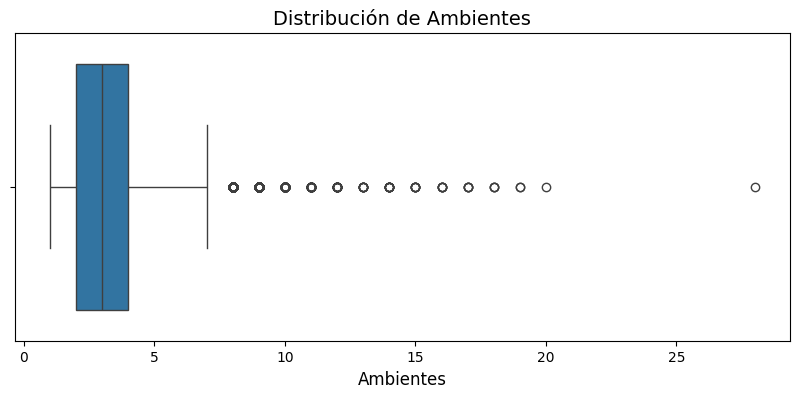

In [407]:
plt.figure(figsize=(10,4))
sns.boxplot(x = "ambientes", data = propiedades_con_outliers)

plt.xlabel('Ambientes', fontsize = 12)
plt.title('Distribución de Ambientes', fontsize = 14)

plt.show()

#### Dormitorios

Para la parte de los *dormitorios*, repetimos el ScatterPlot anterior, pero con los outliers de los *ambientes* ya trabajados. Esta vez vamos a analizar el grafico desde el punto de vista de los *dormitorios*.

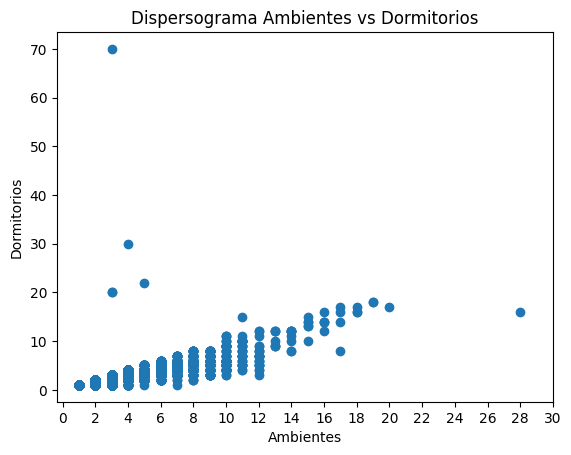

In [408]:
plt.scatter(propiedades_con_outliers['ambientes'], propiedades_con_outliers['dormitorios'])

plt.xticks(range(0, 31, 2))

plt.title("Dispersograma Ambientes vs Dormitorios")
plt.xlabel("Ambientes")
plt.ylabel("Dormitorios")

plt.show()

Lo primero que observamos es que la mayoria de propiedades tienen entre 1 y 10 *dormitorios*, y al ser mayoria, es el grupo de propiedades con valores tipicos de esta variable. Al considerarlos valores tipicos, este va a ser el umbral de analisis, es decir, no vamos a analizar propiedades con 10 *dormitorios* o menos.

Despues vemos que hay un grupo un poco mas reducido que tiene entre 11 y 19 *dormitorios*, y son los primeros outliers del grafico que eventualmente analizaremos, pero que siguen siendo valores verosimiles.

Al final hay otro grupo de pocos puntos, que va de 20 *dormitorios* en adelante, que ya tiene valores menos verosimiles, y son los primeros que vamos a analizar

Al igual que en *ambientes*, gracias al ScatterPlot observamos varias propiedades que tienen muchos *dormitorios* pero pocos *dormitorios* (se ubican a lo largo del eje x, pero estan muy pegados a dicho eje). Aquellas propiedades que esten separadas del grupo mayoritario, pero tambien forman parte de este grupo de puntos que estan cerca del eje x, seran analizados de cerca ya que suponemos que tienen su valor mal imputado.

Pero antes de buscar outliers, retomamos el analisis de propiedades con cantidad de *dormitorios* mayor a la cantidad de *ambientes*.

In [409]:
propiedades_con_outliers[propiedades_con_outliers['ambientes'] < propiedades_con_outliers['dormitorios']]

,id,fecha_inicio,fecha_fin,latitud,longitud,barrio,tipo,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,nombre,nulos
36481,FUByplvzpBHRGXpIB/c+aQ==,2021-07-07,9999-12-31,-34.646502,-58.438508,Flores,Casa,11.0,15.0,323.0,278.0,190000.0,Casa - Flores Sur,2.0
57325,QUMxZwYjb9D0cz4CbjRUAg==,2021-06-10,9999-12-31,-34.562809,-58.476758,Balvanera,Casa,10.0,11.0,257.0,200.0,239000.0,En venta hermosa casa antigua reciclada zona C...,3.0
11443,+0qsKtd+p5A+2Et160DASw==,2021-11-25,2022-01-27,-34.598309,-58.379852,Retiro,Departamento,10.0,11.0,22.0,20.0,62000.0,Departamento - Capital Federal,1.0
50953,ggjz+x/5tq7lCfuDvNUOgA==,2021-12-07,2022-01-27,-34.645539,-58.509067,Villa Luro,Casa,10.0,11.0,767.0,767.0,1200000.0,Increible casa de categoria en inmejorable zona!,3.0
31764,2aHER3AXQs3zb3EegLhmgg==,2021-12-08,2022-01-27,-34.588454,-58.385257,Recoleta,Departamento,5.0,22.0,155.0,144.0,430000.0,Departamento de 2 dormitorios con balcón en ve...,2.0
23890,pVG9sES9De/1eQ+tB90NjQ==,2021-03-26,2021-06-05,-34.591110,-58.400685,Recoleta,Departamento,4.0,30.0,148.0,138.0,380000.0,Departamento. Recoleta. Balcón terraza. Silenc...,1.0
50113,f48xnLslZAFNd6aFyB7MZA==,2021-04-13,2021-06-05,-34.616825,-58.443603,Caballito,Departamento,3.0,20.0,111.0,76.0,245000.0,Excelente y único Departamento en duplex a nue...,3.0
39881,VoyodCc8rftOZHr4TeYcpw==,2021-09-21,2022-02-03,-34.576061,-58.421289,Palermo,Departamento,3.0,20.0,127.0,117.0,650000.0,Departamento - Palermo,1.0
73834,4TbEkLoqy/0c3zakd66/FQ==,2021-09-24,2022-01-27,-34.646632,-58.497902,Villa Luro,Departamento,3.0,70.0,91.0,70.0,135000.0,Departamento - Villa Luro,2.0


A simple vista consideramos claros errores de imputacion, en base a los *ambientes* y las superficies imputadas, valores que corregimos eliminando un 0.

En el caso de la propiedad numero 73834, el numero de *dormitorios* coincide con la superficie cubierta imputada, lo cual tambien consideramos un error de imputacion, en donde imputamos por el promedio de *dormitorios* en propiedades de 3 *ambientes*.

In [410]:
propiedades_con_outliers.loc[23890, 'dormitorios'] = 3

propiedades_con_outliers.loc[50113, 'dormitorios'] = 2

propiedades_con_outliers.loc[73834, 'dormitorios'] = 2

propiedades_con_outliers.loc[39881, 'dormitorios'] = 2

Para la siguiente propiedad, su nombre indica la cantidad de *dormitorios* reales, y en eso nos basamos para la siguiente correccion.

In [411]:
propiedades_con_outliers.loc[31764, 'dormitorios'] = 2

Para el registro numero 11443 consideramos que en realidad se trata de un monoambiente, debido a ambas *superficies* y al valor del *precio*.

In [412]:
propiedades_con_outliers.loc[11443, 'ambientes'] = 1
propiedades_con_outliers.loc[11443, 'dormitorios'] = 1

Para las ultimas 3 propiedades que cumplen esta condicion, no tenemos datos suficientes para realizar una suposicion de a que se refiere en realidad. Por lo tanto, vamos a realizar un algoritmo para corregir este valor:

1.   Agrupamos todos los registros por *tipo*, cantidad de *ambientes* y *precio* (en ese orden), y cada grupo le calculamos el promedio de la cantidad de *dormitorios*.
2.   En cada uno de los 3 registros, filtramos los grupos creados en el paso 1 en base a su *tipo* y a su cantidad de *ambientes*, y a los grupos restantes les calculamos el promedio de la columna *dormitorios*.
3.   El resultado del promedio calculado se imputa en variable *dormitorios* del registro.

In [413]:
propiedades_agrupadas = propiedades_con_outliers.groupby(['tipo',
                                                          'ambientes',
                                                          'precio']).agg({'dormitorios': ['mean']}).reset_index()

In [414]:
propiedades_buscada = propiedades_agrupadas[(propiedades_agrupadas['tipo'] == 'Casa') &
                                            (propiedades_agrupadas['ambientes'] == 11)]

resultado = propiedades_buscada['dormitorios'].mean().round(0)
propiedades_con_outliers.loc[36481, 'dormitorios'] = resultado.item()
resultado

mean    8.0
dtype: float64



---



In [415]:
propiedades_buscada = propiedades_agrupadas[(propiedades_agrupadas['tipo'] == 'Casa') &
                                            (propiedades_agrupadas['ambientes'] == 10)]

resultado = propiedades_buscada['dormitorios'].mean().round(0)
propiedades_con_outliers.loc[57325, 'dormitorios'] = resultado.item()

propiedades_con_outliers.loc[50953, 'dormitorios'] = resultado.item()

resultado

mean    6.0
dtype: float64

Corroboramos que ya no existen mas propiedades con esta condicion.

In [416]:
propiedades_con_outliers[propiedades_con_outliers['ambientes'] < propiedades_con_outliers['dormitorios']].shape

(0, 14)

Ahora si, buscamos outliers en la variable de las primeras 40 filas.

In [417]:
propiedades_con_outliers.sort_values('dormitorios', ascending = False, inplace=True)
propiedades_con_outliers.head(40)

,id,fecha_inicio,fecha_fin,latitud,longitud,barrio,tipo,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,nombre,nulos
49362,KA441xdi8PtuWBvjcAbGOQ==,2021-02-08,2021-03-01,-34.632698,-58.360514,Boca,PH,19.0,18.0,372.0,318.0,159000.0,PH 18 HABITACIONES AV ALMTE BROWN LA BOCA,1.0
8598,yzI9zylc11wllHX16av6jA==,2021-09-30,2021-11-02,-34.632537,-58.360577,Boca,Departamento,19.0,18.0,372.0,318.0,139000.0,DEPARTAMENTO PH 19 AMBIENTES AV ALMTE BROWN BOCA,1.0
65503,8o3ZwoXgOddHoex/irib7g==,2021-04-10,2021-06-05,-34.648922,-58.380522,Barracas,Casa,18.0,17.0,515.0,515.0,135000.0,Casa sobre Lote Propio - A Refaccionar - Barracas,1.0
67195,VuF9cBcZ03aoEcEWAsWGjA==,2021-12-07,2022-01-27,-34.598070,-58.444686,Villa Crespo,PH,17.0,17.0,689.0,598.0,1100000.0,PH 17 AMBIENTES - VILLA CRESPO,1.0
50406,WHu8kgA8Vu692UM8Dz3gnA==,2021-02-24,2022-02-09,-34.638432,-58.369712,Barracas,PH,20.0,17.0,807.0,470.0,640000.0,"VENTA PH EN BARRACAS PB, 1ER PISO Y TERRAZA 80...",1.0
56164,+xTrflFUv4fEGjwpwhP68w==,2021-05-05,2021-06-05,-34.570959,-58.458106,Belgrano,Casa,28.0,16.0,845.0,845.0,950000.0,Imponente casa inglesa de 3 plantas S.S. en ...,1.0
69685,Gj3g5KCtRbYcwZIuh/wJGg==,2021-01-16,2021-08-06,-34.618485,-58.377993,San Telmo,Casa,16.0,16.0,895.0,895.0,1300000.0,Casa en San Telmo,2.0
47127,+SPkA/Y4DHEHf+HIppYFKg==,2021-03-31,2021-04-16,-34.611905,-58.382384,Monserrat,PH,18.0,16.0,587.0,276.0,349000.0,PH DE16 HABITACIONES IDEAL PARA HOSTEL A RECI...,1.0
53678,uqM9/WXFJkEJnXEQefcpRQ==,2021-09-19,2021-09-19,-34.611905,-58.382384,Monserrat,PH,18.0,16.0,587.0,276.0,299900.0,PH DE16 HABITACIONES IDEAL PARA HOSTEL A RECI...,1.0
8082,9OrT+9jZlW4rMGyZYsmNPA==,2021-09-07,2022-02-09,-34.611413,-58.389221,Monserrat,Casa,17.0,16.0,585.0,458.0,880000.0,IMPONENTE CASA 17 AMB CON TERRAZA VENTA MONSERRAT,1.0


Rapidamente dectectamos dos registros que en su *nombre* se describen como hoteles, y por ende son eliminadas (la propiedad numero 30449 puede no aparecer en los primeros 40, dependiendo del orden que tomen las filas que tienen 10 *dormitorios*).

In [418]:
propiedades_con_outliers.drop(30449, inplace = True)

propiedades_con_outliers.drop(36180, inplace = True)

Ademas podemos ver que otra propiedades describe en su *nombre* que posee 2 *ambientes*, por lo que corregimos ambas variables (la propiedad numero 29404 puede no aparecer en los primeros 40, dependiendo del orden que tomen las filas que tienen 10 *dormitorios*).


In [419]:
propiedades_con_outliers.loc[29404, 'ambientes'] = 2
propiedades_con_outliers.loc[29404, 'dormitorios'] = 1

Para terminar con esta variable, lo unico que detectamos son algunas propiedades que tienen misma cantiadad de ambientes que de dormitorios, donde ademas son muchos. Esto es demasiado raro, y ademas da una falsa ilusion de correlacion entre ambas variables, y por estas razones vamos a repetir el algoritmo desarrollado arriba para imputar un valor distinto en estos registros.

In [420]:
propiedades_buscada = propiedades_agrupadas[(propiedades_agrupadas['tipo'] == 'PH') &
                                            (propiedades_agrupadas['ambientes'] == 17)]

resultado = propiedades_buscada['dormitorios'].mean().round(0)
propiedades_con_outliers.loc[67195, 'dormitorios'] = resultado.item()
resultado

mean    16.0
dtype: float64



---



In [421]:
propiedades_buscada = propiedades_agrupadas[(propiedades_agrupadas['tipo'] == 'Casa') &
                                            (propiedades_agrupadas['ambientes'] == 16)]

resultado = propiedades_buscada['dormitorios'].mean().round(0)
propiedades_con_outliers.loc[69685, 'dormitorios'] = resultado.item()
resultado

mean    14.0
dtype: float64



---



In [422]:
propiedades_buscada = propiedades_agrupadas[(propiedades_agrupadas['tipo'] == 'PH') &
                                            (propiedades_agrupadas['ambientes'] == 15)]

resultado = propiedades_buscada['dormitorios'].mean().round(0)
propiedades_con_outliers.loc[65823, 'dormitorios'] = resultado.item()
resultado

mean    14.0
dtype: float64



---



In [423]:
propiedades_buscada = propiedades_agrupadas[(propiedades_agrupadas['tipo'] == 'PH') &
                                            (propiedades_agrupadas['ambientes'] == 12)]

resultado = propiedades_buscada['dormitorios'].mean().round(0)
propiedades_con_outliers.loc[54230, 'dormitorios'] = resultado.item()
resultado

mean    9.0
dtype: float64



---



In [424]:
propiedades_buscada = propiedades_agrupadas[(propiedades_agrupadas['tipo'] == 'Casa') &
                                            (propiedades_agrupadas['ambientes'] == 12)]

resultado = propiedades_buscada['dormitorios'].mean().round(0)
propiedades_con_outliers.loc[13482, 'dormitorios'] = resultado.item()
resultado

mean    6.0
dtype: float64



---



In [425]:
propiedades_buscada = propiedades_agrupadas[(propiedades_agrupadas['tipo'] == 'Casa') &
                                            (propiedades_agrupadas['ambientes'] == 11)]

resultado = propiedades_buscada['dormitorios'].mean().round(0)
propiedades_con_outliers.loc[22407, 'dormitorios'] = resultado.item()
resultado

mean    8.0
dtype: float64

Una vez analizado todos los outliers encontrados, realizamos un BoxPlot de la variable para observar su distribucion con el proceso terminado, y un nuevo ScatterPlot para ver como ser relacionan ambas variables, y determinar si quedaron outliers no observados.

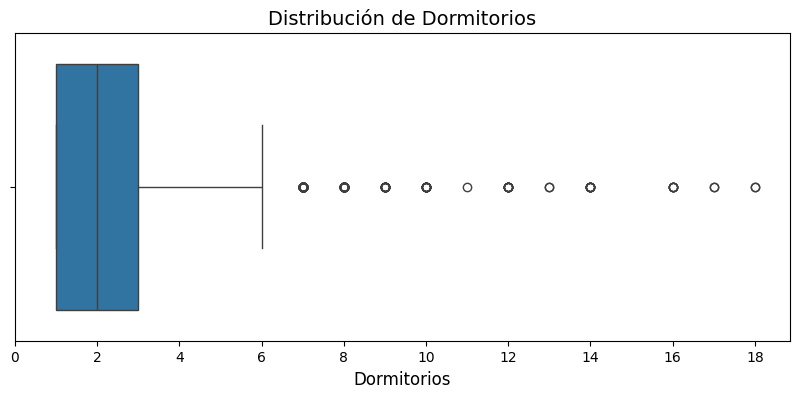

In [426]:
plt.figure(figsize = (10,4))
sns.boxplot(x = "dormitorios", data = propiedades_con_outliers)

plt.xticks(ticks = range(0, 19, 2))
plt.xlabel('Dormitorios', fontsize = 12)
plt.title('Distribución de Dormitorios', fontsize = 14)

plt.show()

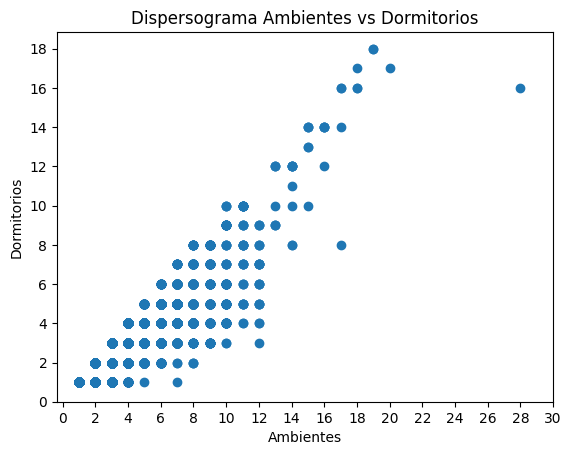

In [427]:
plt.scatter(propiedades_con_outliers['ambientes'], propiedades_con_outliers['dormitorios'])

plt.xticks(range(0, 31, 2))
plt.yticks(range(0, 19, 2))

plt.title("Dispersograma Ambientes vs Dormitorios")
plt.xlabel("Ambientes")
plt.ylabel("Dormitorios")

plt.show()

### Superficies

En esta parte realizamos un analisis similar al anterior pero en este caso con *superficie_total* y *superficie_cubierta*.

#### Superficie Total

Para empezar, hacemos un ScatterPlot de ambas *superficies* donde podemos visualizar todos los registros con ambas variables.

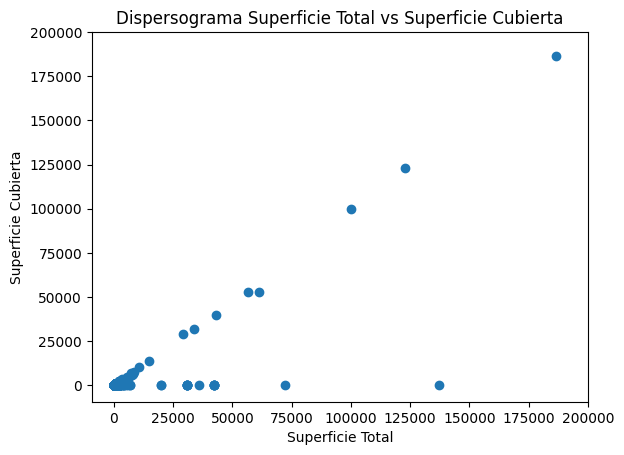

In [428]:
plt.scatter(propiedades_con_outliers['superficie_total'], propiedades_con_outliers['superficie_cubierta'])

plt.xticks(range(0, 200001, 25000))
plt.yticks(range(0, 200001, 25000))

plt.title("Dispersograma Superficie Total vs Superficie Cubierta")
plt.xlabel("Superficie Total")
plt.ylabel("Superficie Cubierta")

plt.show()

Lo primero que observamos es la escala, teniendo en cuenta que la unidad de medida de ambas *superficies* esta en m2, los puntos que esten por sobre el umbral de los 10000 m2 en cualquiera de los ejes representarian supuestas propiedades con mas de una hectarea de terreno, algo que en CABA no tiene sentido para una vivienda. Con este umbral en mente, consideramos que todas las propiedades que tengan mas de una hectarea de terreno no solo son outliers, sino que ademas no son realistas, y por ende las vamos a trabajar.

Esto tambien implica que, todas las propiedades que esten por debajo del umbral no seran consideradas outliers y por ende no se van a analizar.

Al igual que en *ambientes* y *dormitorios*, gracias al ScatterPlot observamos varias propiedades que tienen elevada *superficie total* pero una baja *superficie cubierta* (se ubican a lo largo del eje x, pero estan muy pegados a dicho eje). Como antes, estas propiedades seran analizadas de cerca ya que suponemos que tienen su valor mal imputado.

Gracias a la escala de los graficos, no podemos observar si existen outliers por debajo. Para identificarlos facilmente, los buscamos directamente en el dataframe, considerando que toda propiedad con un terreno menor a 20 m2 no es realista.

In [429]:
propiedades_con_outliers[propiedades_con_outliers['superficie_total'] < 20].shape

(123, 14)

Encontramos solo 123 propiedades con una *superficie total* menor a 20 m2, y por ende las consideramos despreciables y las eliminamos.

In [430]:
propiedades_con_outliers_en_superficie = propiedades_con_outliers[propiedades_con_outliers['superficie_total'] >= 20].copy()
propiedades_con_outliers_en_superficie.shape

(74013, 14)

Ahora buscamos y analizamos las primeras 30 filas con mayor *superficie total*, que son las propiedades encontradas en el ScatterPlot.

In [431]:
propiedades_con_outliers_en_superficie.sort_values('superficie_total', ascending = False, inplace=True)
propiedades_con_outliers_en_superficie.head(30)

,id,fecha_inicio,fecha_fin,latitud,longitud,barrio,tipo,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,nombre,nulos
37447,eQ/SiyES/mXWsSyAzb3k3A==,2021-12-17,9999-12-31,-34.637026,-58.426283,Parque Chacabuco,Casa,3.0,2.0,186426.0,186426.0,250000.0,EXCEPCIONAL CASA DOS FAMILIAS - Parque Chacabuco,4.0
38838,tJ7TjXeyIl+4KPkaPqyAYA==,2021-07-01,9999-12-31,-34.599421,-58.386867,Recoleta,Departamento,5.0,3.0,137000.0,135.0,390000.0,Alquiler Divino 5 Amb. - 137 M² en Barrio Norte,1.0
59350,tHz32dZ72wYshPnoABftrg==,2021-01-07,2021-06-02,-34.569963,-58.481658,Villa Urquiza,PH,4.0,3.0,123000.0,123000.0,165000.0,"VENTA OPORTUNIDAD! PH. IMPECABLE, 4 AMBIENTES",1.0
58526,XzTb7kTEpmAKiyhEGSWz4A==,2021-08-24,2021-09-03,-34.555278,-58.459786,Belgrano,Departamento,4.0,3.0,100068.0,100051.0,420000.0,VENTA PISO 4 AMBIENTES BELGRANO COCHERA BALCON,1.0
51593,WQU6YIN+y4z30xaPRG4LHQ==,2021-03-07,2022-02-09,-34.636532,-58.376406,Barracas,Departamento,4.0,3.0,72060.0,90.0,210000.0,"VENTA SEMIPISO 4 AMBIENTES, EXCELENTE OPORTUIDAD",1.0
37273,BPTyNzwU2D4btCduu8ls3A==,2021-05-29,2021-06-08,-34.578917,-58.429373,Palermo,Departamento,2.0,1.0,61130.0,53030.0,225000.0,VENTA DEPARTAMENTO 2 AMBIENTES PALERMO C/AMENI...,1.0
45488,+YPtNPAzbhoDCLgqF26Q8A==,2021-03-11,2021-04-20,-34.587320,-58.401556,Recoleta,Departamento,2.0,1.0,56740.0,52540.0,175000.0,EXCELENTE DEPARTAMENTO DE 2 AMBIENTES DE CATEG...,1.0
60288,vyRPw0ch6cIj9Ki5yPUneA==,2021-08-18,2021-08-23,-34.550093,-58.483034,Saavedra,Departamento,2.0,1.0,43086.0,40038.0,114000.0,"Venta Departamento 2 amb a Estrenar, Saavedra.",1.0
71400,OC6HYSBo/pqio5ZTLgoPvg==,2021-04-24,2021-06-05,-34.571747,-58.422612,Palermo,Departamento,4.0,3.0,42110.0,222.0,1910920.0,Reventa - Departamento - Palermo Nuevo - Liber...,1.0
67146,HVcSoFtn8OjGl2rbv0GsBw==,2021-04-24,2021-06-05,-34.571747,-58.422612,Palermo,Departamento,5.0,4.0,42110.0,307.0,2890500.0,Reventa - Departamento - Palermo Nuevo - Liber...,1.0


Primero eliminamos un edificio que encontramos el la lista.

In [432]:
propiedades_con_outliers_en_superficie.drop(33962, inplace = True)

 Y ademas eliminamos la propiedad numero 37447 (con *id* = eQ/SiyES/mXWsSyAzb3k3A==) que tiene una exorbitada *superficie* en ambas variables, pero ademas ese registro tenia 4 datos nulos (que no son ambas *superficies* a la vez, ya que no habia registros con esta condicion, por lo tanto una de estas dos imputaciones no fue una prediccion nuestra en la seccion anterior), por lo que no poseemos los datos originales suficientes para intentar predecir su *superficie*. Por estas razones, eliminamos este registro.

In [433]:
propiedades_con_outliers_en_superficie.drop(37447, inplace = True)

Ahora si, observamos los valores atipicos encontrados y detectamos 9 registros que tienen una exagerada *superficie_total* y una baja *superficie_cubierta*, pero que ademas poseen pocos *ambientes* y *dormitorios*. Esto nos indica que son errores de imputacion y tienen varios 0 de mas, y por ende corregimos su valor.

In [434]:
propiedades_con_outliers_en_superficie.loc[38838, 'superficie_total'] = 137

propiedades_con_outliers_en_superficie.loc[18260, 'superficie_total'] = 36

propiedades_con_outliers_en_superficie.loc[14468, 'superficie_total'] = 31

propiedades_con_outliers_en_superficie.loc[25642, 'superficie_total'] = 31

propiedades_con_outliers_en_superficie.loc[4949, 'superficie_total'] = 31

propiedades_con_outliers_en_superficie.loc[7055, 'superficie_total'] = 31

propiedades_con_outliers_en_superficie.loc[10913, 'superficie_total'] = 31

propiedades_con_outliers_en_superficie.loc[36669, 'superficie_total'] = 31

propiedades_con_outliers_en_superficie.loc[20289, 'superficie_total'] = 41

Y para terminar con los errores de imputaicon, a diferencia de los anteriores registros, este si tiene una *superfice_cubierta* elevada, pero aun asi consideramos que estan ambas variables mal imputadas debido a la cantidad de ceros que tienen, y a los datos imputados en las demas variables como *ambientes*, por ejemplo. En este caso, corregimos ambas variables.

In [435]:
propiedades_con_outliers_en_superficie.loc[59350, 'superficie_total'] = 123
propiedades_con_outliers_en_superficie.loc[59350, 'superficie_cubierta'] = 123

Para los demas outliers detectados, y parecido a lo que realizamos para los  *dormitorios*, agrupamos todas las propiedades por *tipo*, *ambientes* y *dormitorios*, y para aquellas propiedades que tengan un valor de *superficie_cubierta* que no cambiaremos, tambien agrupamos por esta variable. Esto resulta en los siguientes dos dataframes, y depende del caso de cada propiedad, trabajamos con uno o con otro.

En ambos dataframe, a cada grupo le calculamos la mediana de la *superfice_total*, y eso utilizaremos para corregir los valores imputados. Para el dataframe que no esta agrupado por *superficie_cubierta*, tambien calculamos la mediana de esta variable para cada grupo.

In [436]:
propiedades_agrupadas = propiedades_con_outliers_en_superficie.groupby(['tipo',
                                                                        'ambientes',
                                                                        'dormitorios',]).agg({'superficie_total': ['median'],
                                                                                              'superficie_cubierta': ['median']}).reset_index()

In [437]:
propiedades_agrupadas_con_superficie_cubierta = propiedades_con_outliers_en_superficie.groupby(['tipo',
                                                                                                'ambientes',
                                                                                                'dormitorios',
                                                                                                'superficie_cubierta']).agg(
                                                                                                    {'superficie_total': ['median']}).reset_index()

Para las siguientes registros, buscamos en el dataframe con las propiedades agrupadas en base a los datos de cada registro en cuestion, y calculamos un promedio de las *superficies* asociadas de los grupos restantes, y con ese promedio, reemplazamos los datos imputados.

In [438]:
propiedades_buscada = propiedades_agrupadas[(propiedades_agrupadas['tipo'] == 'Departamento') &
                                            (propiedades_agrupadas['ambientes'] == 4) &
                                            (propiedades_agrupadas['dormitorios'] == 3)]

resultado = propiedades_buscada['superficie_total'].mean().round(0)
propiedades_con_outliers_en_superficie.loc[58526, 'superficie_total'] = resultado.item()
resultado

median    112.0
dtype: float64

In [439]:
resultado = propiedades_buscada['superficie_cubierta'].mean().round(0)
propiedades_con_outliers_en_superficie.loc[58526, 'superficie_cubierta'] = resultado.item()
resultado

median    100.0
dtype: float64



---



In [440]:
propiedades_buscada = propiedades_agrupadas_con_superficie_cubierta[(propiedades_agrupadas_con_superficie_cubierta['tipo'] == 'Departamento') &
                                                                    (propiedades_agrupadas_con_superficie_cubierta['ambientes'] == 4) &
                                                                    (propiedades_agrupadas_con_superficie_cubierta['dormitorios'] == 3) &
                                                                    (propiedades_agrupadas_con_superficie_cubierta['superficie_cubierta'] == 90)]

resultado = propiedades_buscada['superficie_total'].mean().round(0)
propiedades_con_outliers_en_superficie.loc[51593, 'superficie_total'] = resultado.item()
resultado

median    98.0
dtype: float64



---



In [441]:
propiedades_buscada = propiedades_agrupadas[(propiedades_agrupadas['tipo'] == 'Departamento') &
                                            (propiedades_agrupadas['ambientes'] == 2) &
                                            (propiedades_agrupadas['dormitorios'] == 1)]

resultado = propiedades_buscada['superficie_total'].mean().round(0)
propiedades_con_outliers_en_superficie.loc[37273, 'superficie_total'] = resultado.item()
propiedades_con_outliers_en_superficie.loc[45488, 'superficie_total'] = resultado.item()
propiedades_con_outliers_en_superficie.loc[60288, 'superficie_total'] = resultado.item()
propiedades_con_outliers_en_superficie.loc[9611, 'superficie_total'] = resultado.item()
resultado

median    48.0
dtype: float64

In [442]:
resultado = propiedades_buscada['superficie_cubierta'].mean().round(0)
propiedades_con_outliers_en_superficie.loc[37273, 'superficie_cubierta'] = resultado.item()
propiedades_con_outliers_en_superficie.loc[45488, 'superficie_cubierta'] = resultado.item()
propiedades_con_outliers_en_superficie.loc[60288, 'superficie_cubierta'] = resultado.item()
propiedades_con_outliers_en_superficie.loc[9611, 'superficie_cubierta'] = resultado.item()
resultado

median    42.0
dtype: float64



---



In [443]:
propiedades_buscada = propiedades_agrupadas_con_superficie_cubierta[(propiedades_agrupadas_con_superficie_cubierta['tipo'] == 'Departamento') &
                                                                    (propiedades_agrupadas_con_superficie_cubierta['ambientes'] == 4) &
                                                                    (propiedades_agrupadas_con_superficie_cubierta['dormitorios'] == 3) &
                                                                    (propiedades_agrupadas_con_superficie_cubierta['superficie_cubierta'] == 222)]

resultado = propiedades_buscada['superficie_total'].mean().round(0)
propiedades_con_outliers_en_superficie.loc[71400, 'superficie_total'] = resultado.item()
resultado

median    222.0
dtype: float64



---



In [444]:
propiedades_buscada = propiedades_agrupadas_con_superficie_cubierta[(propiedades_agrupadas_con_superficie_cubierta['tipo'] == 'Departamento') &
                                                                    (propiedades_agrupadas_con_superficie_cubierta['ambientes'] == 5) &
                                                                    (propiedades_agrupadas_con_superficie_cubierta['dormitorios'] == 4)]

resultado = propiedades_buscada['superficie_total'].mean().round(0)
propiedades_con_outliers_en_superficie.loc[22335, 'superficie_total'] = resultado.item()
propiedades_con_outliers_en_superficie.loc[15517, 'superficie_total'] = resultado.item()
propiedades_con_outliers_en_superficie.loc[67146, 'superficie_total'] = resultado.item()
resultado

median    437.0
dtype: float64



---



In [445]:
propiedades_buscada = propiedades_agrupadas_con_superficie_cubierta[(propiedades_agrupadas_con_superficie_cubierta['tipo'] == 'Departamento') &
                                                                    (propiedades_agrupadas_con_superficie_cubierta['ambientes'] == 4) &
                                                                    (propiedades_agrupadas_con_superficie_cubierta['dormitorios'] == 3)]

resultado = propiedades_buscada['superficie_total'].mode().round(0)
resultado

,median
0,107.0
1,340.0


In [446]:
propiedades_con_outliers_en_superficie.loc[6435, 'superficie_total'] = 340



---



In [447]:
propiedades_buscada = propiedades_agrupadas[(propiedades_agrupadas['tipo'] == 'Departamento') &
                                            (propiedades_agrupadas['ambientes'] == 1) &
                                            (propiedades_agrupadas['dormitorios'] == 1)]

resultado = propiedades_buscada['superficie_total'].mean().round(0)
propiedades_con_outliers_en_superficie.loc[14218, 'superficie_total'] = resultado.item()
resultado

median    36.0
dtype: float64

In [448]:
resultado = propiedades_buscada['superficie_cubierta'].mean().round(0)
propiedades_con_outliers_en_superficie.loc[14218, 'superficie_cubierta'] = resultado.item()
resultado

median    32.0
dtype: float64



---



In [449]:
propiedades_buscada = propiedades_agrupadas[(propiedades_agrupadas['tipo'] == 'PH') &
                                            (propiedades_agrupadas['ambientes'] == 4) &
                                            (propiedades_agrupadas['dormitorios'] == 3)]

resultado = propiedades_buscada['superficie_total'].mean().round(0)
propiedades_con_outliers_en_superficie.loc[14426, 'superficie_total'] = resultado.item()
propiedades_con_outliers_en_superficie.loc[37001, 'superficie_total'] = resultado.item()
resultado

median    133.0
dtype: float64

In [450]:
resultado = propiedades_buscada['superficie_cubierta'].mean().round(0)
propiedades_con_outliers_en_superficie.loc[14426, 'superficie_cubierta'] = resultado.item()
propiedades_con_outliers_en_superficie.loc[37001, 'superficie_cubierta'] = resultado.item()
resultado

median    97.0
dtype: float64



---



In [451]:
propiedades_buscada = propiedades_agrupadas[(propiedades_agrupadas['tipo'] == 'Departamento') &
                                            (propiedades_agrupadas['ambientes'] == 5) &
                                            (propiedades_agrupadas['dormitorios'] == 4)]

resultado = propiedades_buscada['superficie_total'].mean().round(0)
propiedades_con_outliers_en_superficie.loc[11378, 'superficie_total'] = resultado.item()
resultado

median    187.0
dtype: float64

In [452]:
resultado = propiedades_buscada['superficie_cubierta'].mean().round(0)
propiedades_con_outliers_en_superficie.loc[11378, 'superficie_cubierta'] = resultado.item()
resultado

median    165.0
dtype: float64

Una vez analizados y trabajados todos los outliers, realizamos un BoxPlot de la variable para ver como se distribuye.

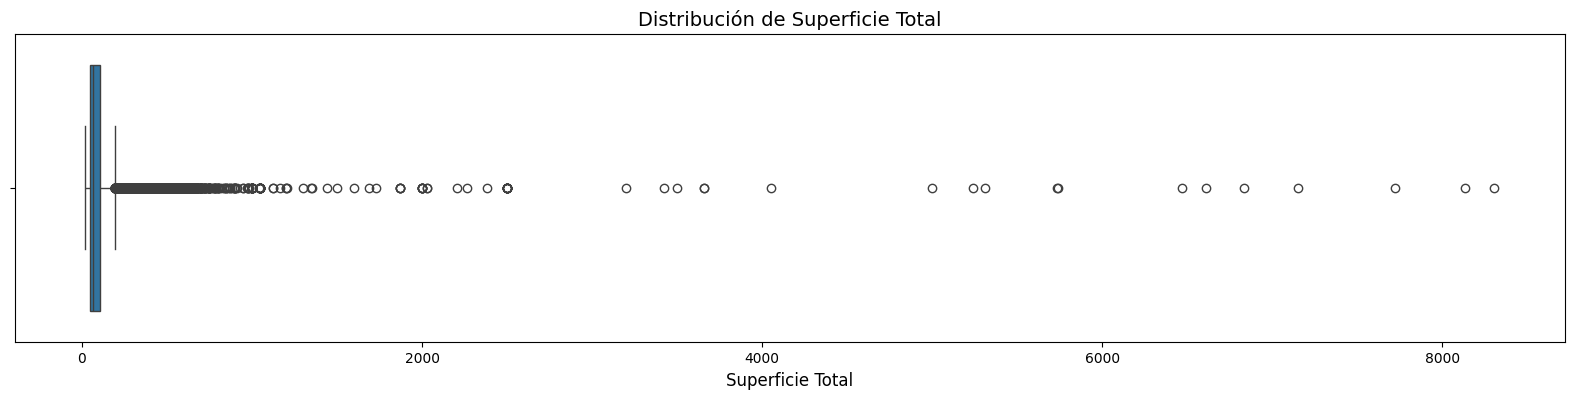

In [453]:
plt.figure(figsize=(20,4))
sns.boxplot(x = "superficie_total", data = propiedades_con_outliers_en_superficie)

plt.xlabel('Superficie Total', fontsize = 12)
plt.title('Distribución de Superficie Total', fontsize = 14)

plt.show()

Observamos en el grafico que todavia existen outliers, pero como dijimos antes, no los consideramos inverosimiles, y como establecimos el umbral en 10000 m2, todas las propiedades con una *superfice_total* menor no seran analizadas.

#### Superficie Cubierta

Igual que con el analisis de *superficie_total*, hacemos un ScatterPlot de ambas *superficies* donde podemos visualizar todos los registros con ambas variables.

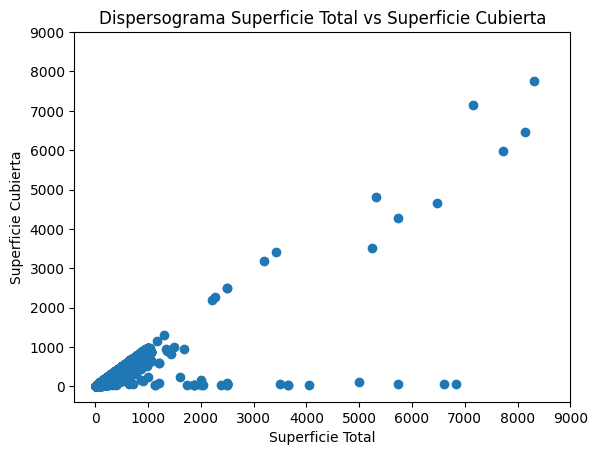

In [454]:
plt.scatter(propiedades_con_outliers_en_superficie['superficie_total'],
            propiedades_con_outliers_en_superficie['superficie_cubierta'])

plt.xticks(range(0, 9001, 1000))
plt.yticks(range(0, 9001, 1000))

plt.title("Dispersograma Superficie Total vs Superficie Cubierta")
plt.xlabel("Superficie Total")
plt.ylabel("Superficie Cubierta")

plt.show()

Lo primero que observamos otra vez es la escala, que con en analisis realizado, ya se normalizo para ambas variables.

Al igual que en el ScatterPlot anterior, observamos varias propiedades que tienen elevada *superficie total* pero una baja *superficie cubierta* (se ubican a lo largo del eje x, pero estan muy pegados a dicho eje). Si estos casos no existieran, vemos que se formaria casi una correlacion lineal perfecta.

Sin embargo, como todos los puntos estan por debajo del umbral establecido, a pesar de ser detectarlos, no van a ser analizados.

A pesar de haber mejorado la escala del ScatterPlot, no podemos observar si existen outliers por debajo. Para identificarlos facilmente, los buscamos directamente en el dataframe, considerando que toda propiedad con una *superfice_cubierta* menor a 20 m2 no es realista.

In [455]:
propiedades_con_outliers_en_superficie[propiedades_con_outliers_en_superficie['superficie_cubierta'] < 20].shape

(81, 14)

A diferencia de *superficie_total*, donde no tenemos referencia de como cambiar la imputacion sin trabajar cada registro individualmente, para las propiedades encontradas les imputamos en *superficie_cubierta* el valor de la *superficie_total*.

In [456]:
propiedades_con_outliers_en_superficie.reset_index(inplace = True, drop=True)

for i in propiedades_con_outliers_en_superficie.index:
  if propiedades_con_outliers_en_superficie.at[i, 'superficie_cubierta'] < 20:
    sup_total = propiedades_con_outliers_en_superficie.at[i, 'superficie_total']
    propiedades_con_outliers_en_superficie.at[i, 'superficie_cubierta'] = sup_total

propiedades_con_outliers_en_superficie[propiedades_con_outliers_en_superficie['superficie_cubierta'] < 20].shape

(0, 14)

Una vez analizados y trabajados todos los outliers, realizamos un BoxPlot de la variable para ver como se distribuye.

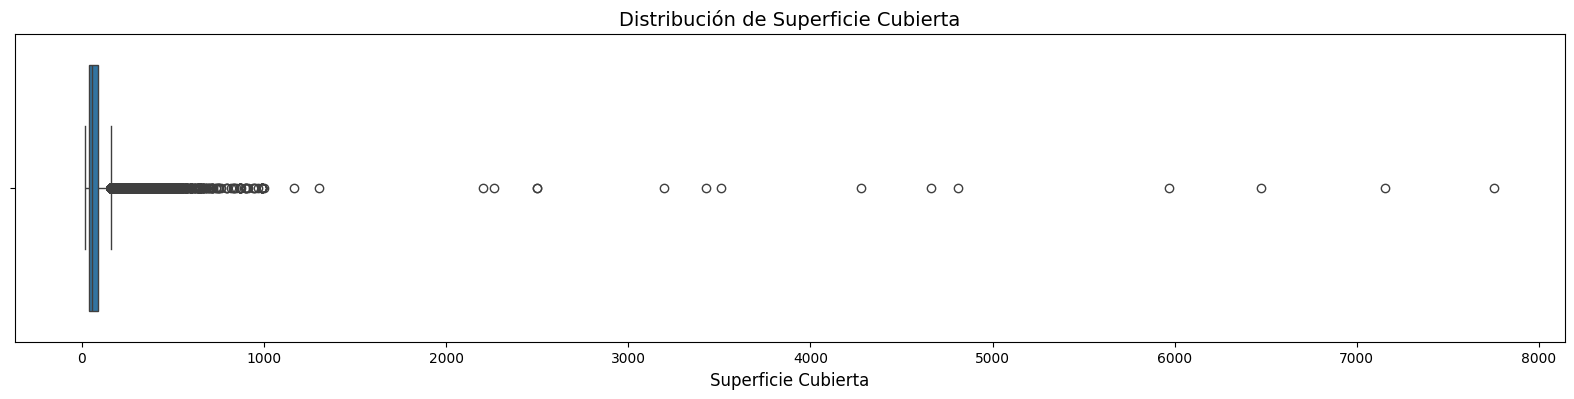

In [457]:
plt.figure(figsize=(20,4))
sns.boxplot(x = "superficie_cubierta", data = propiedades_con_outliers_en_superficie)

plt.xlabel('Superficie Cubierta', fontsize = 12)
plt.title('Distribución de Superficie Cubierta', fontsize = 14)

plt.show()

Al igual que con *superficie_total*, en el grafico todavia se observan outliers, pero como dijimos antes, todas las propiedades con una *superfice_cubierta* por debajo del umbral no seran analizadas.

Volvemos a realizar el ScatterPlot una vez analizadas ambas variables.

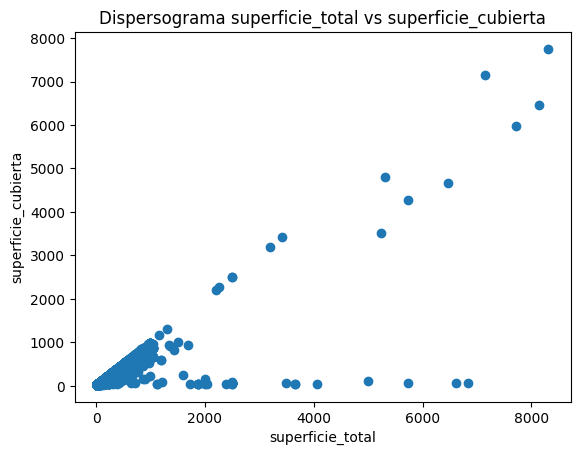

In [458]:
plt.scatter(propiedades_con_outliers_en_superficie['superficie_total'], propiedades_con_outliers_en_superficie['superficie_cubierta'])

plt.title("Dispersograma superficie_total vs superficie_cubierta")
plt.xlabel("superficie_total")
plt.ylabel("superficie_cubierta")

plt.show()

### Precio

Para terminar con el trabajo de outliers, analizamos el *precio* univariada y multivariadamente. Para esta variable no existe un umbral que podamos establecer en donde consideremos que los valores sean o no verosimiles, y por ende sean considerados outliers.

Teniendo esto en mente, utilizamos otros metodos distintos a los realizados para las variables anteriores.

#### Precio Univariadamente

Para el analisis del precio univariadamente, primero calculamos el z-score modificado de todas las propiedades, y creamos una columna nueva llamada *zm-score* en el dataframe con los valores obtenidos.

In [459]:
def z_mod_calculation(serie):
  median = np.median(serie)
  MAD = np.median(np.absolute(serie - median))
  return (serie - median) * 0.6745 / MAD

In [460]:
propiedades_con_outlier_en_precio = propiedades_con_outliers_en_superficie.reset_index(drop = True)
propiedades_con_outlier_en_precio["zm_score"] =  z_mod_calculation(propiedades_con_outlier_en_precio.precio)

Con el coeficiente del *zm-score* calculado, necesitamos establecer el umbral, que si seguimos la regla de oro, deberia ser de 3.5. Pero teniendo en cuenta la cantidad de registros que tenemos en el dataframe, y que no queremos trabajar por demas los outliers, establecemos el umbral del *zm-score* en 7.5.

Buscamos la cantidad de propiedades que pasen el umbral por arriba o por abajo para el umbral establecido.

In [461]:
propiedades_con_outlier_en_precio[(propiedades_con_outlier_en_precio["zm_score"] < -7.5)].shape

(0, 15)

In [462]:
propiedades_con_outlier_en_precio[(propiedades_con_outlier_en_precio["zm_score"] > 7.5)].shape

(2447, 15)

Ahora que ya tenemos los outliers identificados, calculamos las nuevas correlaciones lineales entre las variables cuantitativas para determinar cuales predicen mejor el *precio*.

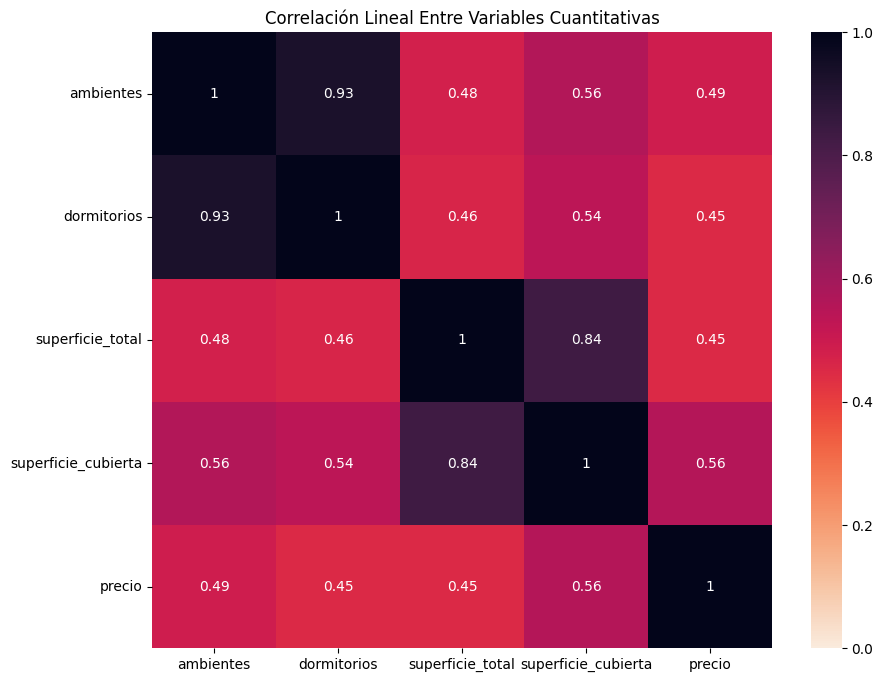

In [463]:
plt.figure(figsize = (10,8))
heatmap_de_propiedades = propiedades_con_outlier_en_precio.drop(['id',
                                                                 'latitud',
                                                                 'longitud',
                                                                 'nulos',
                                                                 'fecha_inicio',
                                                                 'fecha_fin',
                                                                 'barrio',
                                                                 'tipo',
                                                                 'nombre',
                                                                 'zm_score'],
                                                                axis='columns')

heatmap = sns.heatmap(heatmap_de_propiedades.corr(), annot = True, cmap = 'rocket_r', vmin = 0, vmax = 1)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation = 0, ha = 'right');

heatmap.set_title('Correlación Lineal Entre Variables Cuantitativas');

Visto el HeatMap, agrupamos las propiedades por *barrio*, *tipo*, *ambientes*, y *dormitorios*, calculando la mediana del *precio* de cada grupo.

In [464]:
propiedades_agrupadas_con_precio = propiedades_con_outlier_en_precio.groupby(['barrio',
                                                                              'tipo',
                                                                              'ambientes',
                                                                              'dormitorios']).agg({'precio': ['median']}).reset_index()

Parecido al algoritmo que realizamos para las variables anteriores, buscamos en el dataframe con las propiedades agrupadas en base a los datos de cada registro en cuestion, y calculamos un promedio del *precio* asociado a los grupos restantes, y con ese promedio, reemplazamos los datos imputados.

In [465]:
for indice, fila in propiedades_con_outlier_en_precio.iterrows():
  if (fila['zm_score'] > 7.5):
    tipo = propiedades_con_outlier_en_precio.at[indice, 'tipo']
    ambientes = propiedades_con_outlier_en_precio.at[indice, 'ambientes']
    dormitorios = propiedades_con_outlier_en_precio.at[indice, 'dormitorios']

    propiedades_buscada = propiedades_agrupadas_con_precio[(propiedades_agrupadas_con_precio['tipo'] == tipo) &
                                                           (propiedades_agrupadas_con_precio['ambientes'] == ambientes) &
                                                           (propiedades_agrupadas_con_precio['dormitorios'] == dormitorios)]

    precio = propiedades_buscada['precio'].mean().iloc[0]
    propiedades_con_outlier_en_precio.at[indice, 'precio'] = round(precio, 0)

Y para verificar que el metodo no comete errores, compramobamos la cantidad de nulos del dataframe.

In [466]:
propiedades_con_outlier_en_precio.isna().sum()

id                     0
fecha_inicio           0
fecha_fin              0
latitud                0
longitud               0
barrio                 0
tipo                   0
ambientes              0
dormitorios            0
superficie_total       0
superficie_cubierta    0
precio                 0
nombre                 0
nulos                  0
zm_score               0
dtype: int64

Ahora volvemos a calcular el *zm-score*, y observamos los cambios.

In [467]:
propiedades_con_outlier_en_precio["zm_score"] =  z_mod_calculation(propiedades_con_outlier_en_precio.precio)

In [468]:
propiedades_con_outlier_en_precio[(propiedades_con_outlier_en_precio["zm_score"] < -7.5)].sort_values('precio').shape

(0, 15)

In [469]:
propiedades_con_outlier_en_precio[(propiedades_con_outlier_en_precio["zm_score"] > 7.5)].sort_values('precio').shape

(528, 15)

Obtuvimos como resultado 528 propiedades que siguen superando el *zm_score*. A pesar de que siguen superando el umbral, no vamos a seguir trabajando los *precios* univariadamente para no sobre trabajar la variable.

Para terminar con el analisis univariado, realizamos un BoxPlot de la variable para ver como se distribuye.

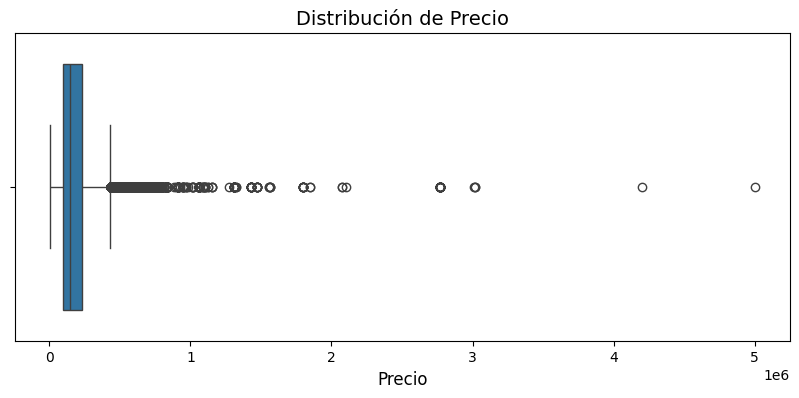

In [470]:
plt.figure(figsize=(10,4))
sns.boxplot(x = "precio", data = propiedades_con_outlier_en_precio)

plt.xlabel('Precio', fontsize = 12)
plt.title('Distribución de Precio', fontsize = 14)

plt.show()

#### Precio Multivariadamente

Ahora, tratamos de detectar outliers en la variable *precio* de forma multivariada, relacionandola con la *superficie_total*.

Primero, visualizamos la correlacion entre ambas en un ScatterPlot. En el grafico esperamos detectar puntos con altos valores de precio y superfice a la vez, ya que en el analisis previo de ambas variables ya detectamos sus posibles outliers por separado. Es decir, esperamos detectar puntos sobre la recta `y = ax` (con a una constante que sea aproximadamente 1).


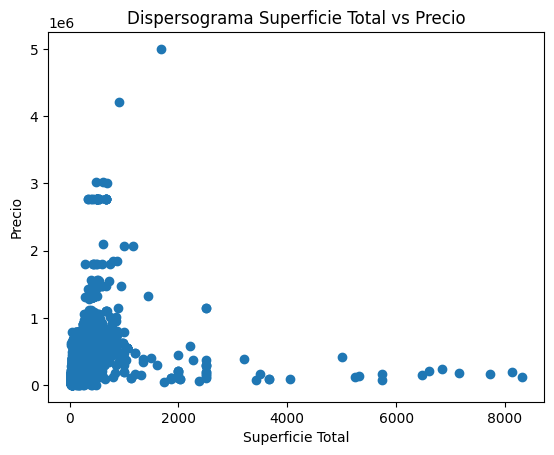

In [471]:
plt.scatter(propiedades_con_outlier_en_precio['superficie_total'], propiedades_con_outlier_en_precio['precio'])

plt.title("Dispersograma Superficie Total vs Precio")
plt.xlabel("Superficie Total")
plt.ylabel("Precio")

plt.show()

Observamos en el grafico que los puntos esperados no existen, mas bien obtuvimos los puntos que ya habian sido detectados en los analisis de outliers previos y que decidimos no modificar ni eliminar. Por lo tanto concluimos que, en el ScatterPlot, no pudimos detectar outliers que no habian sido detectados previamente.

Para reforzar nuestro analisis, realizamos el metodo de Distancia de Mahalanobis entre ambas variables. Con el coeficiente obtenido para cada propiedad, creamos un dataframe con ambas variables y sus respectivos coeficientes.

In [472]:
def calculate_mahalanobis_distance(dataset, col1, col2, frac=1):
    X = dataset[[f'{col1}', f'{col2}']].copy()
    sample_X = X.sample(frac=frac)

    mu = sample_X.mean()
    X_diff = X - mu
    X_diff = X_diff.values.T

    cov = np.cov(sample_X.values.T)
    inv_cov = np.linalg.inv(cov)
    W = la.sqrtm(inv_cov)

    Wx = np.matmul(W, X_diff)
    X['mahalanobis'] = [np.dot(Wx[:, i], Wx[:, i]) for i in range(Wx.shape[1])]

    return X

In [473]:
propiedades_mahalanobis = calculate_mahalanobis_distance(propiedades_con_outlier_en_precio, 'superficie_total', 'precio')
propiedades_mahalanobis.sort_values('mahalanobis', ascending = False, inplace = True)
propiedades_mahalanobis

,superficie_total,precio,mahalanobis
24,8306.0,129000.0,5142.145794
25,8136.0,203550.0,4898.829862
26,7720.0,167894.0,4419.841640
27,7153.0,177807.0,3783.838240
28,6836.0,240000.0,3428.868628
...,...,...,...
21958,95.0,195000.0,0.000186
22552,93.0,192000.0,0.000172
21808,95.0,192000.0,0.000067
22189,94.0,193000.0,0.000038


Con el dataframe creado, buscamos un umbral del coeficiente de Mahalanobis para determinar que propiedades son outliers multivariados. Teniendo en cuenta la regla de oro para el *zm_score*, planteamos un umbral de 3.

In [474]:
propiedades_mahalanobis[propiedades_mahalanobis["mahalanobis"] > 3].tail(10)

,superficie_total,precio,mahalanobis
15236,119.0,450000.0,3.008943
2259,301.0,398000.0,3.004221
2388,300.0,400000.0,3.002953
2280,300.0,400000.0,3.002953
2319,300.0,400000.0,3.002953
2126,310.0,250000.0,3.002340
3035,270.0,440000.0,3.002316
3054,270.0,440000.0,3.002316
21865,95.0,438000.0,3.002286
1985,317.0,315000.0,3.000133


Obtenemos en la cola del dataframe, propiedades que por sus valores no solo no las consideramos outliers multivariados, sino que consideramos que son perfectamente normales. Sospechamos que se debe a la cantidad de registros que tenemos en el dataframe, por lo tanto vamos a aumentar el umbral abruptamente a 100.

In [475]:
propiedades_mahalanobis[propiedades_mahalanobis["mahalanobis"] > 100].tail(10)

,superficie_total,precio,mahalanobis
140,800.0,1850000.0,110.846867
75,1351.0,346197.0,110.265488
754,431.0,1800000.0,108.112931
76,1350.0,385000.0,108.073036
729,436.0,1800000.0,107.927561
696,448.0,1798333.0,107.262485
587,477.0,1800000.0,106.550542
463,508.0,1800000.0,105.678639
254,600.0,1800000.0,103.949174
158,750.0,1798333.0,103.674161


Volvemos a obtener valores que no podemos considerar outliers multivariados, asi que volvemos a aumentar el umbral abruptamente a 1000.

In [476]:
propiedades_mahalanobis[propiedades_mahalanobis["mahalanobis"] > 1000]

,superficie_total,precio,mahalanobis
24,8306.0,129000.0,5142.145794
25,8136.0,203550.0,4898.829862
26,7720.0,167894.0,4419.841640
27,7153.0,177807.0,3783.838240
28,6836.0,240000.0,3428.868628
29,6609.0,210000.0,3211.936312
30,6470.0,149900.0,3097.370156
31,5741.0,85144.0,2451.681854
32,5736.0,169000.0,2420.780133
33,5312.0,145000.0,2078.064049


Volvemos a obtener valores que no podemos considerar outliers multivariados, de hecho, estamos obteniendo en el dataframe las propiedades que ya habiamos detectado en los analisis previos, ya que todas las propiedades obtenidas en el ultimo filtro tienen una superficie muy elevada, y habian sido detectadas en el analisis de la variable.

Esto refuerza nuestra conclusion de la observacion del ScatterPlot que hicimos de *precio* y *superficie_total*, con lo que podemos ya confirmar que no detectamos outliers multivariados de precio con *superficie_total* que no se habian detectado univariadamente.

Para finalizar nuestro analisis, vamos a graficar distintas correlaciones entre *precio* y otras variables que ya habiamos realizado.

Primero, el analisis de *precio* por mes inicial.

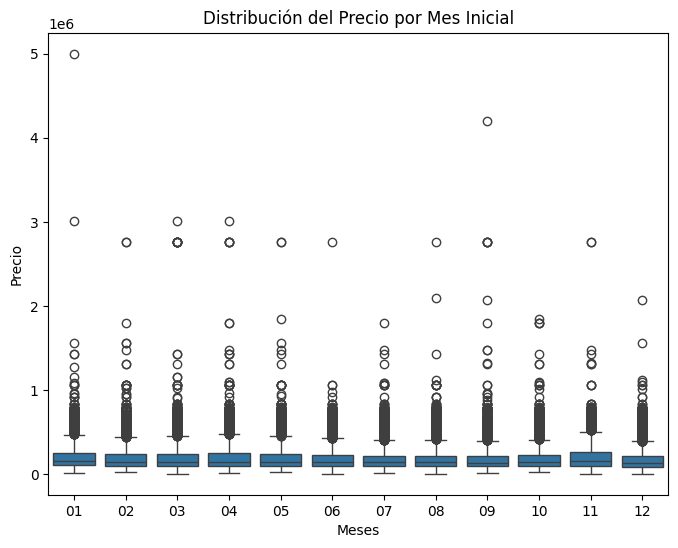

In [477]:
propiedades_por_fecha = propiedades_con_outlier_en_precio.sort_values('fecha_inicio')
meses = propiedades_por_fecha['fecha_inicio'].tolist()
lista_de_meses = []

for mes in meses:
  date = mes.split('-')
  lista_de_meses.append(date[1])

propiedades_por_fecha['mes'] = lista_de_meses

plt.figure(figsize=(8, 6))
sns.boxplot(x = "mes", y = 'precio', data = propiedades_por_fecha)

plt.xlabel('Meses')
plt.ylabel('Precio')
plt.title('Distribución del Precio por Mes Inicial')

plt.show()

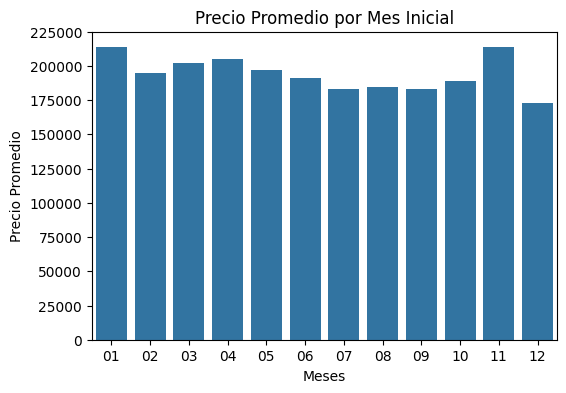

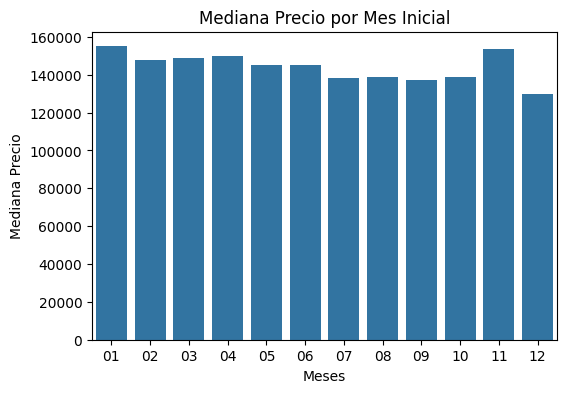

In [478]:
plt.figure(figsize=(6, 4))
propiedades_por_fecha_promedio = propiedades_por_fecha.groupby(['mes'])['precio'].mean().reset_index()
propiedades_por_fecha_promedio.rename(columns = {'precio': 'precio_promedio'}, inplace = True)
sns.barplot(x='mes', y='precio_promedio', data=propiedades_por_fecha_promedio)

plt.yticks(range(0, 225001, 25000))
plt.xlabel('Meses')
plt.ylabel('Precio Promedio')
plt.title('Precio Promedio por Mes Inicial')

plt.show()

plt.figure(figsize=(6, 4))
propiedades_por_fecha_mediana = propiedades_por_fecha.groupby(['mes'])['precio'].median().reset_index()
propiedades_por_fecha_mediana.rename(columns = {'precio': 'precio_mediana'}, inplace = True)
sns.barplot(x='mes', y='precio_mediana', data=propiedades_por_fecha_mediana)

plt.yticks(range(0, 160001, 20000))
plt.xlabel('Meses')
plt.ylabel('Mediana Precio')
plt.title('Mediana Precio por Mes Inicial')

plt.show()

Detectamos cambios en los graficos con respecto a los que hicimos en secciones anteriores, sin embargo, no podemos concluir que haya algun tipo de efecto inflacionario en las propiedades.

Segundo, la distribucion del *precio* por *barrio*.

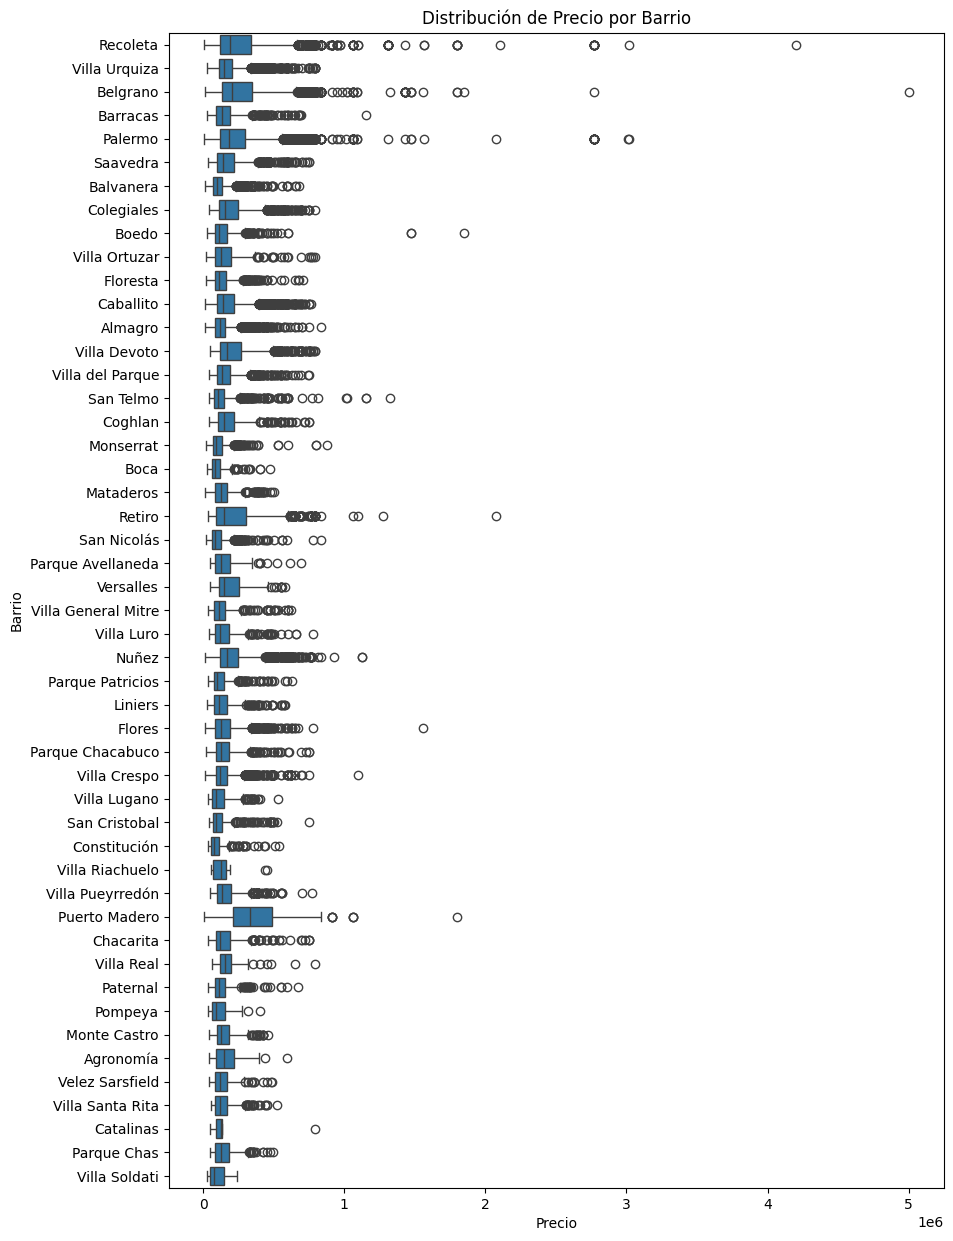

In [479]:
plt.figure(figsize = (10,15))
sns.boxplot(y = 'barrio', x = 'precio', data = propiedades_con_outlier_en_precio)

plt.ylabel('Barrio')
plt.xlabel('Precio')
plt.title('Distribución de Precio por Barrio')

plt.show()

Con los outliers ya trabajados, se pueden visualizar de mejor manera las distribuciones de cada *barrio*, y se distinguen mejor que *barrios* tienen *precios* mas elevados que el resto.

Tercero, un HeatMap para visualizar las correlaciones obtenidas.

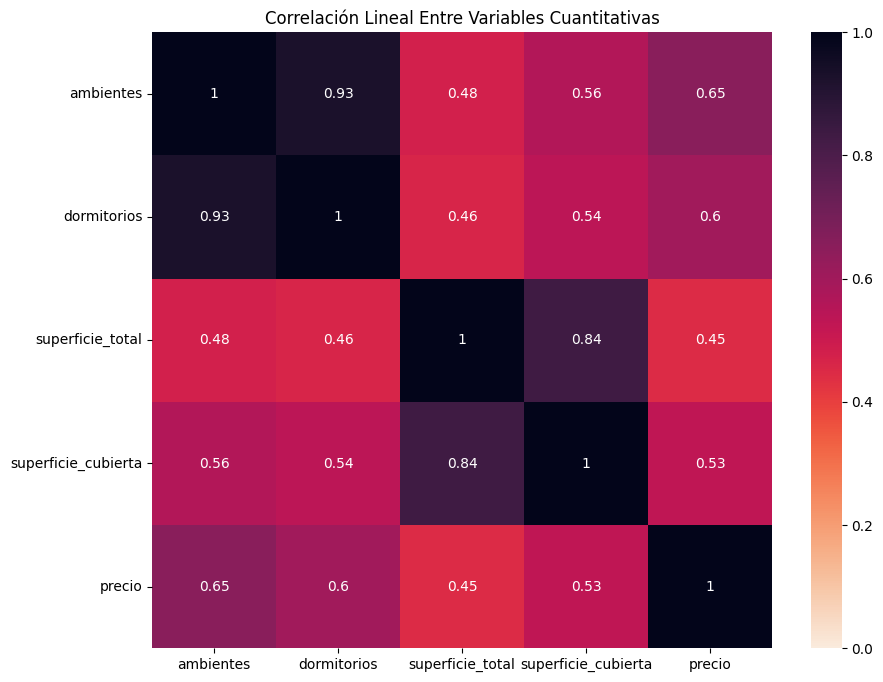

In [480]:
plt.figure(figsize = (10,8))
heatmap_de_propiedades = propiedades_con_outlier_en_precio.drop(['id',
                                                                 'latitud',
                                                                 'longitud',
                                                                 'nulos',
                                                                 'fecha_inicio',
                                                                 'fecha_fin',
                                                                 'barrio',
                                                                 'tipo',
                                                                 'nombre',
                                                                 'zm_score'],
                                                                axis='columns')

heatmap = sns.heatmap(heatmap_de_propiedades.corr(), annot = True, cmap = 'rocket_r', vmin = 0, vmax = 1)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation = 0, ha = 'right');

heatmap.set_title('Correlación Lineal Entre Variables Cuantitativas');

Observamos la diferencia con el primer HeatMap realizado, donde habia solo 3 correlaciones, y ahora todas las variables tienen una minima correlacion lineal, lo que ademas nos da la razon en nuestra sospecha de algunas variables que no tenian correlacion lineal.

Y podemos confirmar que las parejas *ambientes*-*dormitorios* y *superficie_total*-*superficie_cubierta* definitivamente estan correlacionadas linealmente.

Cuarto, para finalizar el trabajo, un pairplot de todas las variables cuantitativas para visualizar lo determinado en el HeatMap.

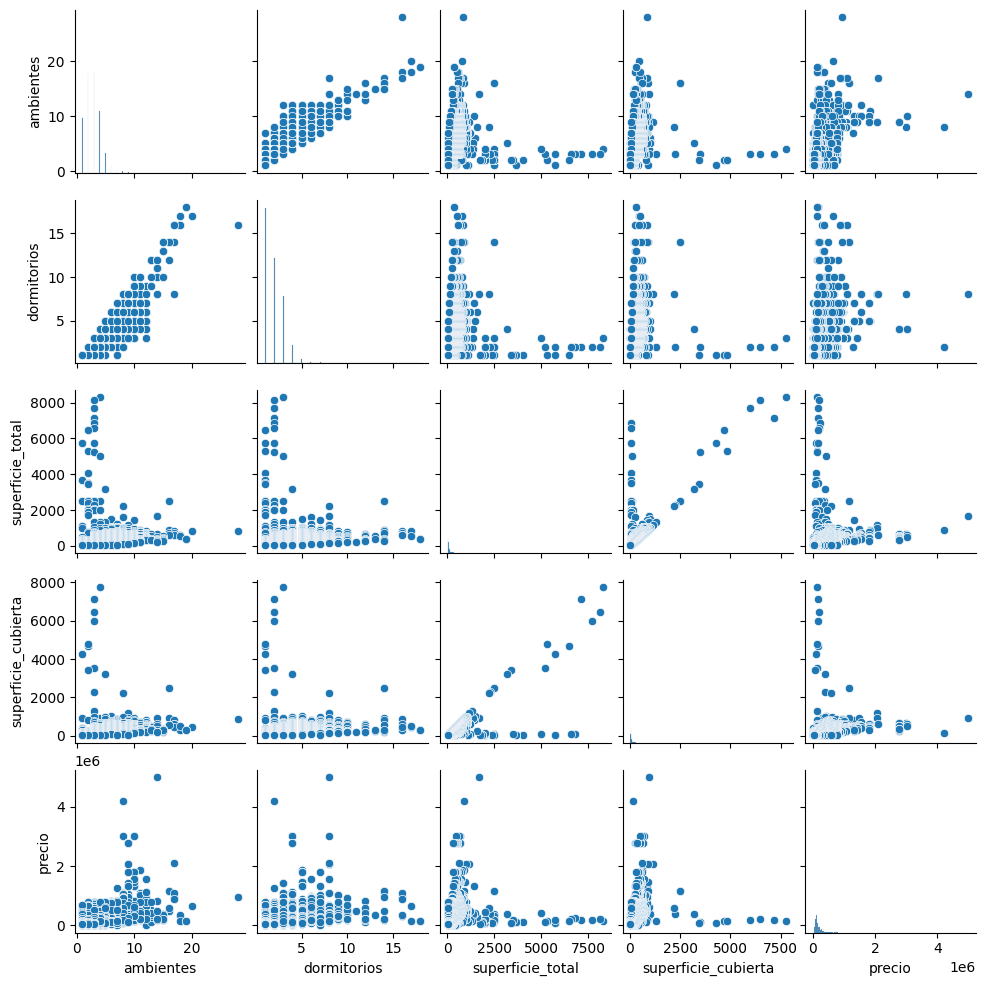

In [481]:
sns.pairplot(heatmap_de_propiedades, height=2)

# Exportar final

Con el preprocesamiento terminado, eliminamos las columnas que creamos para analizar las variables.

In [482]:
columnas_a_eliminar = ['nulos', 'zm_score']
propiedades_final = propiedades_con_outlier_en_precio.drop(columnas_a_eliminar, axis = 'columns')

Y por ultimo, exportamos el dataframe final que vamos a utilizar para entrenar modelos, y el dataframe de test a dos archivos csv.

In [483]:
ruta_archivo = '/content/dataframe_punto1.csv'
propiedades_con_outlier_en_precio.to_csv(ruta_archivo, index=False)

In [484]:
ruta_archivo = '/content/dataframe_test.csv'
propiedades_test.to_csv(ruta_archivo, index=False)